# Exam Machine Learning with Python

Submitted by : 

Dries Luts (dries-luts@hotmail.com)<br />
Bino Maiheu (binomaiheu@gmail.com)<br />
Marijke Van De Steene (marijkevandesteene@hotmail.com)<br />

This notebook is submitted by the group above for the course exame "Machine Learning with Python", taught by Bart Van Rompaye. Course IPVW-
ICES 2024, **due date**: 2024-07-03 23:59. 

# Changelog

- **2024-06-05** [MV] : Initial version
- **2024-06-06** [BM] : Consolidated structure, imported initial analysis from notebooks 
- **2024-06-18** [BM] : Consolidated structure: Walkthrough in team / Finalized data preparation
- **2024-06-18** [MVDS] : Added data preparation steps on score
- **2024-06-19** [BM] : Fixed issue w.r.t kNN imputer to apply for score
- **2024-06-23** [MVDS] : Random forest model tuning, Calibration / applied explainability / removed some try out code



# Initialisation

## Packages

In [1]:
# -- Importing packages
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.distributions.empirical_distribution import ECDF
import scipy.stats as stats
import scikitplot as skplt 
import pickle

from pathlib import Path

In [2]:
# -- Import Machine learning libraries
from sklearn.preprocessing import MinMaxScaler, StandardScaler  # for preprocessing & scaling
from sklearn.preprocessing import PolynomialFeatures  # for polynomial features preprocessing
from sklearn.impute import SimpleImputer, KNNImputer   # for missing values imputation
from sklearn.model_selection import train_test_split  # train-test splits
from sklearn.model_selection import StratifiedKFold  # K-fold resampling, stratified
from sklearn.model_selection import GridSearchCV  # Hyperparameter tuning
from sklearn.calibration import CalibratedClassifierCV  # Hyperparameter tuning with calibration
from sklearn.calibration import calibration_curve  # calibration curve plotting
from sklearn.calibration import CalibrationDisplay  # calibration curve plotting
from sklearn.metrics import confusion_matrix  # performance metrics, confusion matrix
from sklearn.metrics import classification_report  # performance matrix classifiaction report
from sklearn.metrics import roc_auc_score  # Area Under Receiver Operating Characteristics
from sklearn.metrics import roc_curve  # ROC
from sklearn.metrics import RocCurveDisplay  # ROC plotting
from sklearn.metrics import accuracy_score  # performance metric accuracy (0/1) score
from sklearn.metrics import precision_score  # performance metric
from sklearn.linear_model import LogisticRegression  # Logistic regression modelling
from sklearn.neighbors import KNeighborsClassifier  # KNN
from sklearn.ensemble import RandomForestClassifier  # Random Forest for classification
from sklearn.ensemble import GradientBoostingClassifier  # GBM for classification
from sklearn.neighbors import KNeighborsRegressor  # KNN
from sklearn.ensemble import RandomForestRegressor  # Random Forest for classification
from sklearn.ensemble import GradientBoostingRegressor  # GBM for classification
from sklearn.svm import SVC  # SVM for classification
from sklearn.utils import resample  # Resampling
from imblearn.over_sampling import SMOTE  # Synthetic upsampling

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold

from sklearn.inspection import permutation_importance
from sklearn.linear_model import LinearRegression

In [3]:
# -- Import Defined functions
import common_used_functions as cuf

## Notebook setup

In [4]:
# -- Setting plotting style
plt.style.use('seaborn-v0_8-darkgrid')

In [5]:
# -- Jupyter magic command to show plots inline immediately
%matplotlib inline

In [6]:
# -- Setting seed
seed = 43
np.random.seed(seed)

In [7]:
# -- pandas display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Importing datafiles

In [8]:
# -- Loading the dataset for scoring Russian hotel guests
data_file_path = Path('input')  # Set to the path of folder where you can find 'train_V2.csv' and 'score.csv'

train_filename = data_file_path / 'train_V2.csv'
score_filename = data_file_path / 'score.csv'
dict_filename = data_file_path / 'dictionary.csv'

# -- Training & scoring data
train_V2 = pd.read_csv(train_filename)
score = pd.read_csv(score_filename)

# -- We load the dictionare as a dict
#    Note that small edits were made to the original file 
#    - tenure_yrs occurred twice, this was corrected
#    - income_am did not occur, was added...
dictionary = pd.read_csv(dict_filename, sep=';', header=None).set_index(0).to_dict(orient="dict")[1]

# -- Some feedback 
print('Training set shape: {}' .format(train_V2.shape))
print('Score set shape: {}' .format(score.shape))

Training set shape: (5000, 53)
Score set shape: (500, 50)


In [9]:
train_V2.head()

,income_am,profit_last_am,profit_am,damage_am,damage_inc,crd_lim_rec,credit_use_ic,gluten_ic,lactose_ic,insurance_ic,spa_ic,empl_ic,cab_requests,married_cd,bar_no,sport_ic,neighbor_income,age,marketing_permit,urban_ic,dining_ic,presidential,client_segment,sect_empl,prev_stay,prev_all_in_stay,divorce,fam_adult_size,children_no,tenure_mts,tenure_yrs,company_ic,claims_no,claims_am,nights_booked,gender,shop_am,shop_use,retired,gold_status,score1_pos,score1_neg,score2_pos,score2_neg,score3_pos,score3_neg,score4_pos,score4_neg,score5_pos,score5_neg,outcome_profit,outcome_damage_inc,outcome_damage_amount
0,227.0,0.0,3201.0,888.0,6.0,15000.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,True,2.0,1.0,28936.0,37.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,3.0,2.0,476.0,40.0,0.0,0.0,0.0,209.0,M,0.000000,0.0,0.0,0.0,0.467768,0.98334,NaN,NaN,NaN,NaN,0.838147,0.082288,NaN,NaN,1791.66,0,0.00
1,268.0,16.0,1682.0,0.0,0.0,750.0,0.0,0.0,0.0,1.0,1.0,0.0,7.0,True,3.0,0.0,16674.0,18.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,27.0,2.0,0.0,0.0,0.0,4.0,M,0.000000,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.955259,1672.78,1,829.66
2,283.0,23.0,1673.0,0.0,0.0,750.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,True,4.0,0.0,32552.0,21.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,95.0,8.0,0.0,0.0,0.0,6.0,M,0.000000,0.0,0.0,0.0,NaN,NaN,0.232375,0.099529,NaN,NaN,NaN,NaN,0.101955,1.743020,1001.40,0,0.00
3,227.0,0.0,1685.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,True,8.0,1.0,32252.0,37.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,3.0,2.0,NaN,NaN,0.0,0.0,0.0,4.0,V,0.000000,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.889793,NaN,NaN,NaN,NaN,1785.59,0,0.00
4,4091.0,1028.0,3425.0,785.0,2.0,14000.0,0.0,0.0,1.0,0.0,1.0,0.0,4.0,False,2.0,1.0,29605.0,26.0,0.0,1.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,2.0,0.0,354.0,30.0,0.0,0.0,0.0,3.0,V,1454.210627,1.0,0.0,0.0,NaN,NaN,NaN,NaN,0.330503,0.766294,0.490486,0.542445,NaN,NaN,3140.74,0,0.00


We first analyse some high level stuff regarding the loaded data

In [10]:
# -- print list of features
print('Training set features : ')
print(train_V2.columns)

Training set features : 
Index(['income_am', 'profit_last_am', 'profit_am', 'damage_am', 'damage_inc',
       'crd_lim_rec', 'credit_use_ic', 'gluten_ic', 'lactose_ic',
       'insurance_ic', 'spa_ic', 'empl_ic', 'cab_requests', 'married_cd',
       'bar_no', 'sport_ic', 'neighbor_income', 'age', 'marketing_permit',
       'urban_ic', 'dining_ic', 'presidential', 'client_segment', 'sect_empl',
       'prev_stay', 'prev_all_in_stay', 'divorce', 'fam_adult_size',
       'children_no', 'tenure_mts', 'tenure_yrs', 'company_ic', 'claims_no',
       'claims_am', 'nights_booked', 'gender', 'shop_am', 'shop_use',
       'retired', 'gold_status', 'score1_pos', 'score1_neg', 'score2_pos',
       'score2_neg', 'score3_pos', 'score3_neg', 'score4_pos', 'score4_neg',
       'score5_pos', 'score5_neg', 'outcome_profit', 'outcome_damage_inc',
       'outcome_damage_amount'],
      dtype='object')


In [11]:
# -- compare the feaures in the training & score sets
print("Features in the training set but not in the scoring set (target variables) : ")
set(train_V2.columns).difference(set(score.columns))

Features in the training set but not in the scoring set (target variables) : 


{'outcome_damage_amount', 'outcome_damage_inc', 'outcome_profit'}

In [12]:
# -- Adding an index to the 
train_V2.insert(0, 'Id', range(0, 0 + len(train_V2)))
if 'Id' in train_V2.columns:
    train_V2 = train_V2.set_index('Id')

# 0-500 voor score of lengte train_v2 > lengte  + 500?

score.insert(0, 'Id', range(0, 0 + len(score)))
if 'Id' in score.columns:
    score = score.set_index('Id')


In [13]:
# -- Print some info
train_V2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5000 entries, 0 to 4999
Data columns (total 53 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   income_am              4947 non-null   float64
 1   profit_last_am         4947 non-null   float64
 2   profit_am              4947 non-null   float64
 3   damage_am              4954 non-null   float64
 4   damage_inc             4947 non-null   float64
 5   crd_lim_rec            4947 non-null   float64
 6   credit_use_ic          4947 non-null   float64
 7   gluten_ic              4947 non-null   float64
 8   lactose_ic             4947 non-null   float64
 9   insurance_ic           4947 non-null   float64
 10  spa_ic                 4970 non-null   float64
 11  empl_ic                4999 non-null   float64
 12  cab_requests           4912 non-null   float64
 13  married_cd             5000 non-null   bool   
 14  bar_no                 4947 non-null   float64
 15  sport_ic 

# Dataset preparation

Ok, now that we have our data loaded, lets dive into the anlysis.  In this section we shall check for consistency, handle missing values, outliers etc... We first start  with extracting categorical and numerical features

## Extraction of categorical and numerical features

It's not clear immediately what the categorical and numerical features are in the dataset, this is important for later on (e.g. imputation of missing values), so we spend a little time analysing this. 


Here we aim to get a list of feature names (i.e. column names) one with categorical features, one with numerical features

In [14]:
# -- test the number of unique values in the dataframe
train_nunique = train_V2.nunique()
train_nunique

income_am                2109
profit_last_am           1452
profit_am                2139
damage_am                 616
damage_inc                 11
crd_lim_rec                41
credit_use_ic               2
gluten_ic                   2
lactose_ic                  2
insurance_ic                2
spa_ic                      2
empl_ic                     2
cab_requests               17
married_cd                  2
bar_no                     47
sport_ic                    2
neighbor_income          3042
age                        72
marketing_permit            2
urban_ic                    2
dining_ic                   2
presidential                2
client_segment              6
sect_empl                   6
prev_stay                   2
prev_all_in_stay            2
divorce                     2
fam_adult_size              4
children_no                 7
tenure_mts                586
tenure_yrs                 58
company_ic                  2
claims_no                  10
claims_am 

In [15]:
# train_nunique[ train_nunique == 2 ]

We see quite some variables with only 2 unique values, and from looking at the dictionary, those likely will be binary features : true/false. 

Additionally, we see that the features `client_segment` as well as `sect_empl` also only contain 6 unique values and from the dictionary (client and employment sectors), it is safe to assume that those features are also categorical. Some additional features also contain a limited amount of unique values, however, judging from the dictionary those should not be considered categorical : 
- `fam_adult_size`: number of adults in family
- `children_no` : number of children

So, in summary we can create the following classification for the features (categorical/numerical):

In [16]:
# the categorical input features are those with 2 unique values, as well as client_segment and sect_empl, but not the ones which start with outcome, those are target features
categorical_input_features = [ 'client_segment', 'sect_empl', *train_nunique[ (train_nunique == 2) & ~train_nunique.index.str.startswith('outcome_') ].index.to_list() ]

# the numerical input features the other ones but not the ones which start with outcome, those are target features
numerical_input_features = train_V2.columns[ ~train_V2.columns.isin(categorical_input_features) & ~train_V2.columns.str.startswith('outcome_')].to_list()

# these are the target features in the dataframe
target_features = ['outcome_profit', 'outcome_damage_amount', 'outcome_damage_inc']

### Categorical input features

These are the resulting categorical input features :

In [17]:
for ft in categorical_input_features:
    print(f"- {ft} : {dictionary[ft]}")

- client_segment : segment of client
- sect_empl : employment sector
- credit_use_ic : previously used hotel credit
- gluten_ic : allergic to gluten
- lactose_ic : lactose intolerant
- insurance_ic : use of hotel insurance
- spa_ic : spa user
- empl_ic : employee of chain
- married_cd : marital status
- sport_ic : user of sports facilities
- marketing_permit : marketing contact allowed
- urban_ic : from urban region (vs rural)
- dining_ic : use of in-hotel restaurants
- presidential : previous use of presidential suite
- prev_stay : previous stay at hotel indicator
- prev_all_in_stay : previous stay at hotel with all-in formula indicator
- divorce : indicator divorce
- company_ic : indicator company card
- gender : gender code
- shop_use : used hotel shop court
- retired : retired indicator
- gold_status : gold client profile


### Numerical input features
These are the resulting numerical features 

In [18]:
for ft in numerical_input_features:
    print(f"- {ft} : {dictionary[ft]}")

- income_am : income (added)
- profit_last_am : profit across second last visit
- profit_am : total profit across visits  (excluding last visit)
- damage_am : total amount of damages  (excluding last visit)
- damage_inc : number of damage incidents  (excluding last visit)
- crd_lim_rec : Recommended limit hotel credit 
- cab_requests : number of cab requests
- bar_no : number of hotel bar visits
- neighbor_income : Mean taxable income of neighborhood
- age : age
- fam_adult_size : number of adults in family
- children_no : number of known children
- tenure_mts : months as client in months
- tenure_yrs : years as client in years
- claims_no : number of claims against hotel
- claims_am : compensations payed after claims
- nights_booked : total nights booked at chain
- shop_am : amount spent in shop
- score1_pos : positivity' score, given by staff, as quantile, from hotel 1
- score1_neg : negativity' score, given by staff, as quantile, from hotel 1
- score2_pos : positivity' score, given 

### Target features
These are the target features (initially... in the further analysis, this will be refined)

In [19]:
for ft in target_features:
    print(f"- {ft} : {dictionary[ft]}")

- outcome_profit : profit of last visit
- outcome_damage_amount : damage amount after last visit
- outcome_damage_inc : damage incident in last visit


### Discussion on memory consumption

Ideally, to reduce the **memory footprint** of this data, we reallocate the categorical variables to a smaller integer, or even a boolean. Currently the variables are in memory as 64 bit floats which is way to large. At the moment we leave things as they are & come back to this if time permits. Note that we will make some alterations onwards as some features, like gender are "objects", i.e. strings. 

## Dataset consistency tests

### Feature types

Some observations in the output of `train_V2.info()` above here: 

- all the variables seem to be numeric (encoded as float64), except for:
- `gender` : object contains 'M' or 'V', we will replace those with 0 and 1 for consistency with the other variables
- `married_cd` : appears to be a boolean, so clearly this is categorical

Let's first look at the feature types. 

In [20]:
train_V2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5000 entries, 0 to 4999
Data columns (total 53 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   income_am              4947 non-null   float64
 1   profit_last_am         4947 non-null   float64
 2   profit_am              4947 non-null   float64
 3   damage_am              4954 non-null   float64
 4   damage_inc             4947 non-null   float64
 5   crd_lim_rec            4947 non-null   float64
 6   credit_use_ic          4947 non-null   float64
 7   gluten_ic              4947 non-null   float64
 8   lactose_ic             4947 non-null   float64
 9   insurance_ic           4947 non-null   float64
 10  spa_ic                 4970 non-null   float64
 11  empl_ic                4999 non-null   float64
 12  cab_requests           4912 non-null   float64
 13  married_cd             5000 non-null   bool   
 14  bar_no                 4947 non-null   float64
 15  sport_ic 

In [21]:
score.info()

<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, 0 to 499
Data columns (total 50 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   income_am         496 non-null    float64
 1   profit_last_am    496 non-null    float64
 2   profit_am         496 non-null    float64
 3   damage_am         497 non-null    float64
 4   damage_inc        496 non-null    float64
 5   crd_lim_rec       496 non-null    float64
 6   credit_use_ic     496 non-null    float64
 7   gluten_ic         496 non-null    float64
 8   lactose_ic        496 non-null    float64
 9   insurance_ic      496 non-null    float64
 10  spa_ic            498 non-null    float64
 11  empl_ic           500 non-null    float64
 12  cab_requests      495 non-null    float64
 13  married_cd        500 non-null    bool   
 14  bar_no            496 non-null    float64
 15  sport_ic          496 non-null    float64
 16  neighbor_income   479 non-null    float64
 17  ag

In [22]:
# -- re-assign the gender to 0 or 1 
train_V2['gender'] = train_V2['gender'].map({'M': 0, 'V': 1}) # M = 0, V = 1
score['gender'] = score['gender'].map({'M': 0, 'V': 1}) # M = 0, V = 1

### Histogram analysis of the score variables

When looking a bit more closely to the distribution of the score variables, we noticed that score5_neg did not conform to the rest of the data. In the introductory document to the exam, it was stated that these score variables represented quantiles. Likely in case of hotel 5, this is still a raw score which has not been converted to a quantile yet.

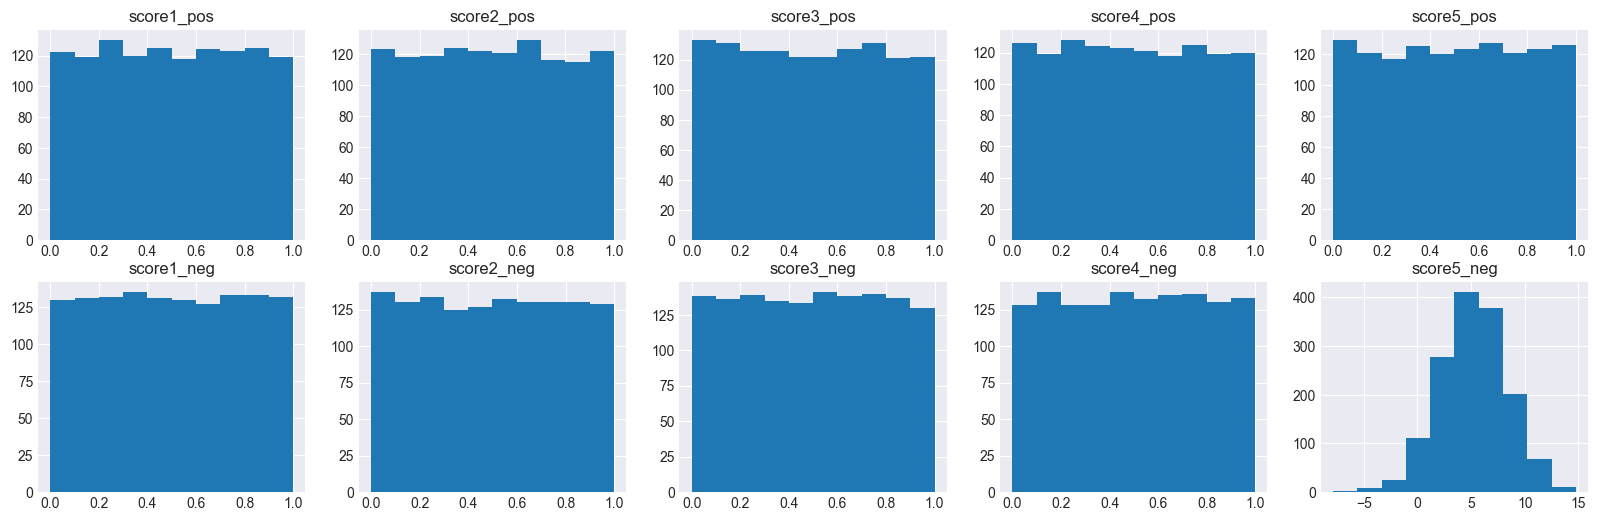

In [23]:
fig, axs = plt.subplots(2, 5, figsize=(20,6))
for k in range(5):     
    train_V2[f"score{k+1}_pos"].hist(ax=axs[0][k])
    train_V2[f"score{k+1}_neg"].hist(ax=axs[1][k])

    axs[0][k].set_title(f"score{k+1}_pos")
    axs[1][k].set_title(f"score{k+1}_neg")

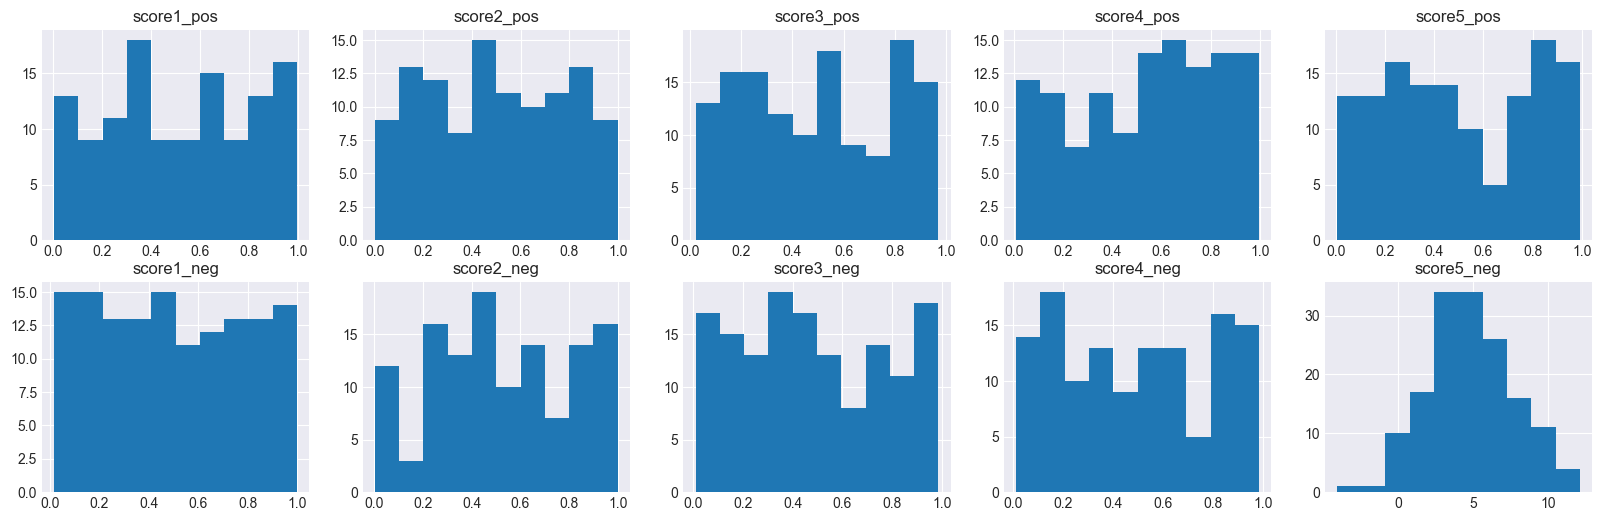

In [24]:
# histogram score
fig, axs = plt.subplots(2, 5, figsize=(20,6))
for k in range(5):     
    score[f"score{k+1}_pos"].hist(ax=axs[0][k])
    score[f"score{k+1}_neg"].hist(ax=axs[1][k])

    axs[0][k].set_title(f"score{k+1}_pos")
    axs[1][k].set_title(f"score{k+1}_neg")

Let's in case of hotel5 convert this score to a quantile value. To do this, we have to be a bit carefull. An easy way to handle this would be to calculate the percentile rank for the score, e.g. : 

```python
train_V2["score5_neg_uniform"]  = train_V2["score5_neg"].rank(method='max', pct=True)
```

However, it would be rather difficult to apply this consistently on the independent score dataset later on. So, as an alternative we will get the quantiles from the cumulative distribution function, we can do this via the emprical cdf or rescale the distribution to zero mean and unit variance, assuming it's shape to be - let's say - Gaussian and compute the quantiles from that cdf, keeping things simple, we opted to calculate the z-score, assume the distirbution is roughly Gaussian(without rigorously checking, as this probably won't affect the result significantly) in the following way, using `scipy.stats.norm.cdf`. For discussion see: https://github.com/Marijkevandesteene/MachineLearning/issues/22

In [25]:
train_V2["score5_neg_uniform"] = ( train_V2["score5_neg"] - train_V2["score5_neg"].mean() ) / train_V2["score5_neg"].std()
train_V2["score5_neg_uniform"] = stats.norm.cdf(train_V2["score5_neg_uniform"])
score["score5_neg_uniform"] = ( score["score5_neg"] - train_V2["score5_neg"].mean() ) / train_V2["score5_neg"].std()
score["score5_neg_uniform"] = stats.norm.cdf(score["score5_neg_uniform"])

Text(0.5, 1.0, 'score5_neg_uniform vs score5_pos')

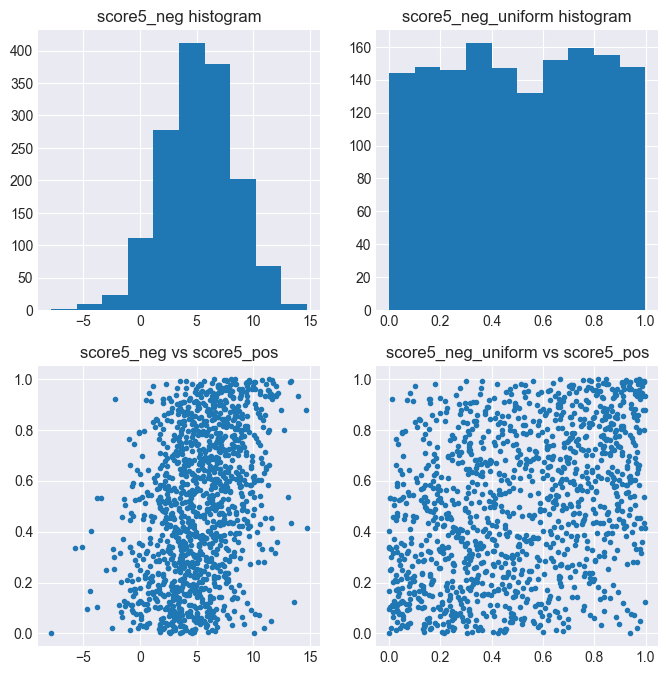

In [26]:
# -- a small check
fig, axs = plt.subplots(2,2, figsize=(8,8))
train_V2["score5_neg"].hist(ax=axs[0][0])
train_V2["score5_neg_uniform"].hist(ax=axs[0][1])

axs[1][0].plot(train_V2["score5_neg"], train_V2["score5_pos"], '.')
axs[1][1].plot(train_V2["score5_neg_uniform"], train_V2["score5_pos"], '.')

axs[0][0].set_title("score5_neg histogram")
axs[0][1].set_title("score5_neg_uniform histogram")
axs[1][0].set_title("score5_neg vs score5_pos")
axs[1][1].set_title("score5_neg_uniform vs score5_pos")

Text(0.5, 1.0, 'score5_neg_uniform vs score5_pos')

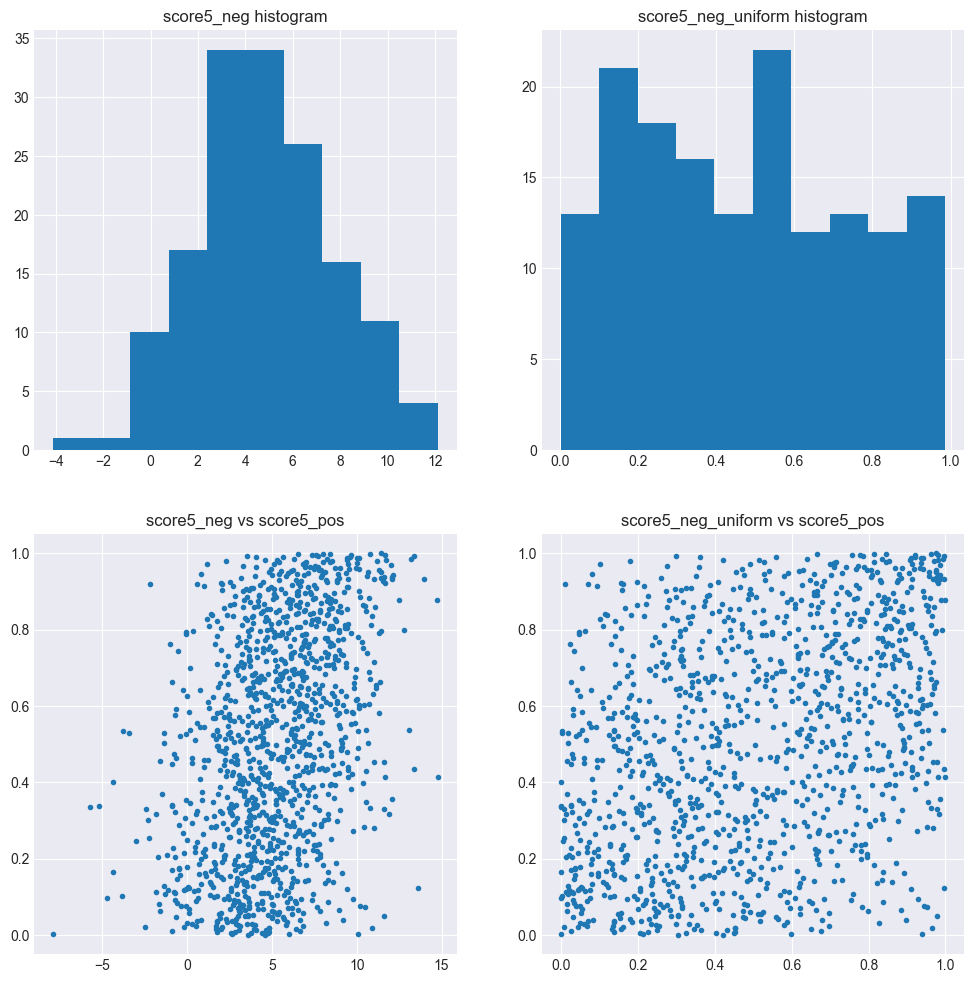

In [27]:
# -- a similar check on score data
fig, axs = plt.subplots(2,2, figsize=(12,12))
score["score5_neg"].hist(ax=axs[0][0])
score["score5_neg_uniform"].hist(ax=axs[0][1])

axs[1][0].plot(train_V2["score5_neg"], train_V2["score5_pos"], '.')
axs[1][1].plot(train_V2["score5_neg_uniform"], train_V2["score5_pos"], '.')

axs[0][0].set_title("score5_neg histogram")
axs[0][1].set_title("score5_neg_uniform histogram")
axs[1][0].set_title("score5_neg vs score5_pos")
axs[1][1].set_title("score5_neg_uniform vs score5_pos")

In [28]:
#  -- and now replace the variable in the dataset for training data and for score
train_V2['score5_neg'] = train_V2['score5_neg_uniform']
train_V2.drop(columns=['score5_neg_uniform'], inplace=True)
score['score5_neg'] = score['score5_neg_uniform']
score.drop(columns=['score5_neg_uniform'], inplace=True)

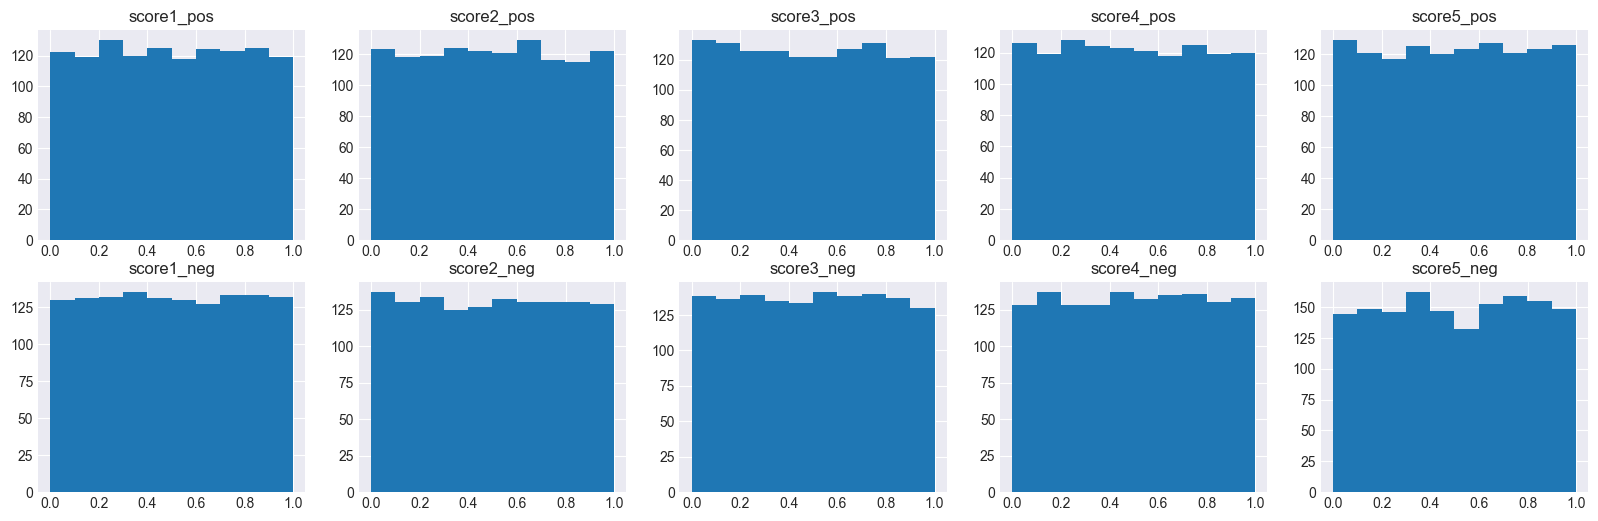

In [29]:
# -- make a small plot to check the results:
fig, axs = plt.subplots(2, 5, figsize=(20,6))
for k in range(5):     
    train_V2[f"score{k+1}_pos"].hist(ax=axs[0][k])
    train_V2[f"score{k+1}_neg"].hist(ax=axs[1][k])

    axs[0][k].set_title(f"score{k+1}_pos")
    axs[1][k].set_title(f"score{k+1}_neg")

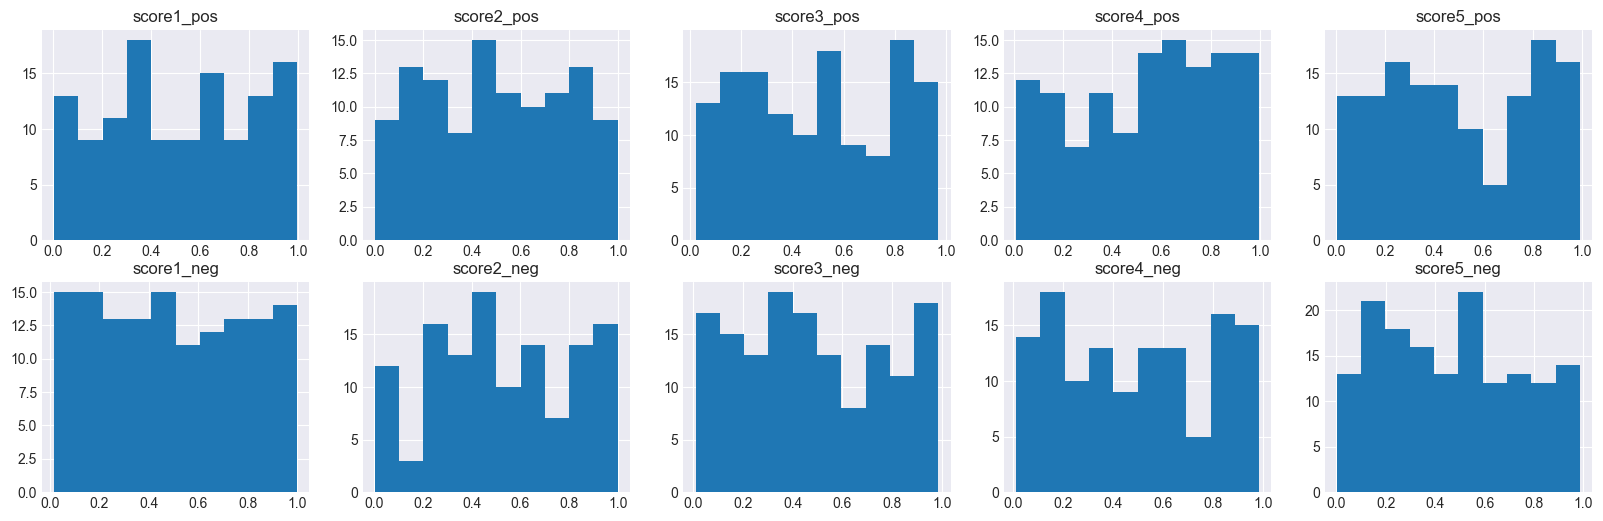

In [30]:
fig, axs = plt.subplots(2, 5, figsize=(20,6))
for k in range(5):     
    score[f"score{k+1}_pos"].hist(ax=axs[0][k])
    score[f"score{k+1}_neg"].hist(ax=axs[1][k])

    axs[0][k].set_title(f"score{k+1}_pos")
    axs[1][k].set_title(f"score{k+1}_neg")

### Consistency between damage incurred and damage amount

In [31]:
print(f"Max damage amount when no damage is incurred : {train_V2.loc[train_V2['outcome_damage_inc'] == 0, 'outcome_damage_amount'].max()}")
print(f"Min damage amount when damage is incurred : {train_V2.loc[train_V2['outcome_damage_inc'] == 1, 'outcome_damage_amount'].min()}")

Max damage amount when no damage is incurred : 0.0
Min damage amount when damage is incurred : 0.0


Ha, so there are cases for which there is damage incurred, but the amount of the damage is 0 ... interesting

## Handling of  missing data


### Methodology and TODO's 

1. Getting missing values descending per feature
2. Verwerken van de scores
3. Find instances with missing observations (% of missing for a lot of features is equal > it appears these values for these featues are missing for the same instances)

### General analysis

In [32]:
# Getting an idea about total missing values
total_missings = train_V2.isnull().sum().sort_values(ascending=False)  # total missng values, sorted
print("Top 20 of most missing features : ")
total_missings.head(20)  # Show top 20 most missing features

Top 20 of most missing features : 


score2_pos         3791
score4_pos         3777
score1_pos         3775
score5_pos         3768
score3_pos         3739
score2_neg         3696
score1_neg         3686
score4_neg         3676
score3_neg         3633
score5_neg         3507
tenure_yrs          392
tenure_mts          392
neighbor_income     239
shop_use             88
presidential         88
cab_requests         88
dining_ic            88
company_ic           53
claims_no            53
income_am            53
dtype: int64

<Axes: title={'center': 'Number of missing values per feature'}>

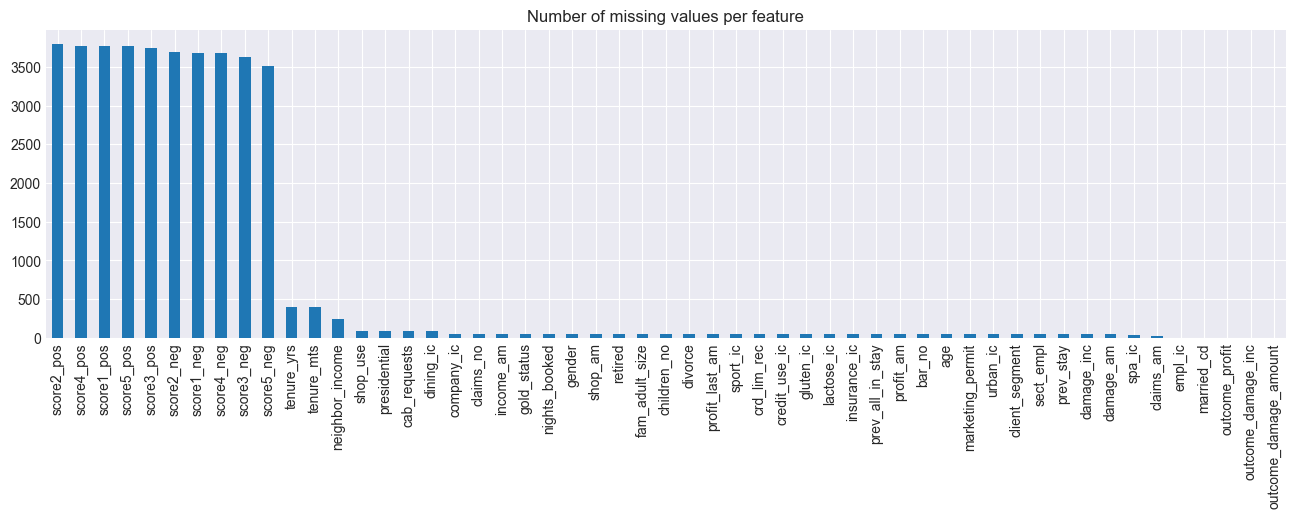

In [33]:
total_missings.plot(kind='bar', figsize=(16,4), title="Number of missing values per feature")

In [34]:
# Getting an idea about percentage missing values
pct_missings = train_V2.isnull().mean().sort_values(ascending=False)  # average (%) missng values, sorted
#pct_missings.head(20)  # Show top 20 most missing features

<Axes: ylabel='pct. missing [%]'>

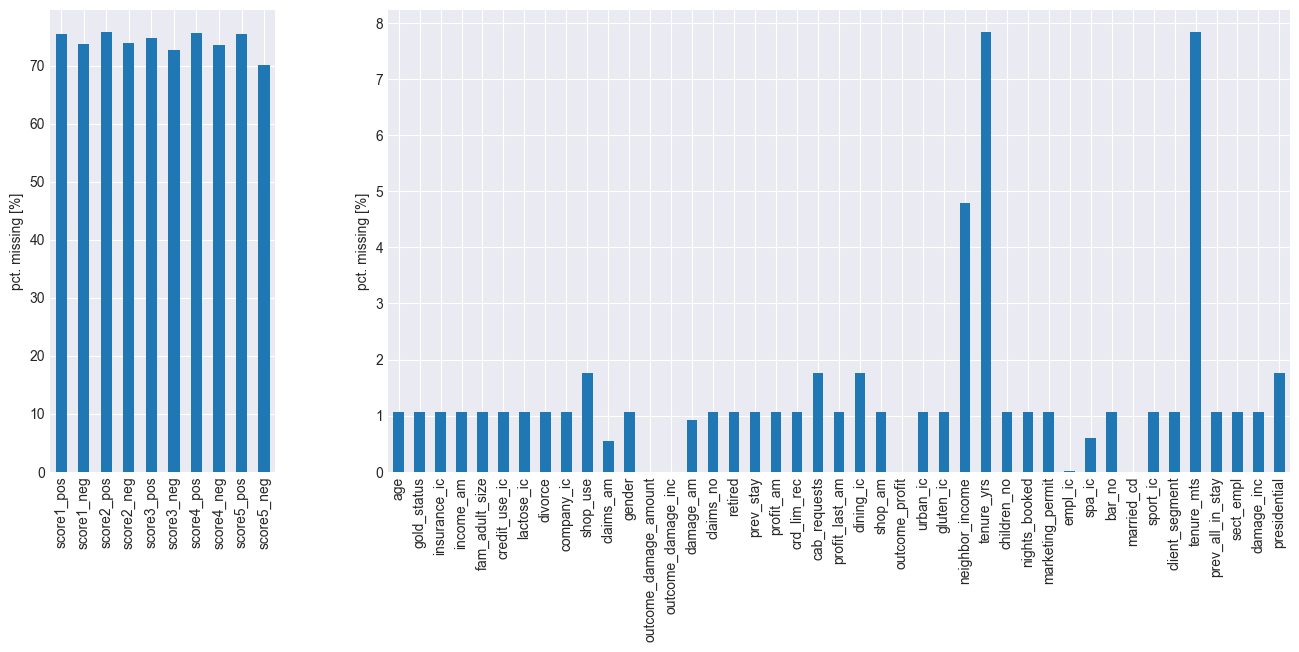

In [35]:
score_vars = [ f"score{i+1}_{xx}" for i in range(5) for xx in ("pos", "neg") ]
other_vars = list(set(train_V2.columns).difference(score_vars))

fig, axs = plt.subplots(1, 2, figsize=(16,6), gridspec_kw={'width_ratios': [1, 4]})

axs[0].set_ylabel('pct. missing [%]')
axs[1].set_ylabel('pct. missing [%]')

pct_missings[score_vars].multiply(100.).plot(kind='bar', ax=axs[0])
pct_missings[other_vars].multiply(100.).plot(kind='bar', ax=axs[1])

Some conclusions :
- no missing values inthe outcomes
- a lot of missing values in the scores given by the hotels (> 70% of the data), however despite the large quantity of missing data, it doesn't seem a good idea to throw away this data as the score given by other hotels in the chain may be a very relevant predictor, so we decide to keep these features and treat the missing values (which in its own right may be relevant information as well). 
- tenure_mts does have almost 10% missing --> perhaps we should not just drop it, but re-use the years !!
- it's striking that a large number of features report the same amount of missing values, so these are probably a set of rows which we can drop

### Treatment of the score values

The imputation of the score values is somewhat tricky. There is potentially a lot of information encoded in there, but also > 70 % of missing values. First of all we do not know from the dataset what hotels correspond to 1, 2, ... 5 also we do not know from the description that hotel1 from the training set corresponds to hotel1 in the score set. By aggregating the scores (.e.g. calculating a mean over the hotels for both the positivity and negativity scores, we can already get rid of a lot of missing values, however the downside is that the information on what hotel did give the score is lost then). Still this may be a good way forward as we don't know for sure whether the hotels in the training & score set correspond (though it's probably safe to assume so). One caveat with this approach is that we would be averaging quantile values, which may not be entirely consistent so it would probably be better to average the original scores, but then we would have to make assumptions on the underlying distribution of these original scores. For a discussion we refer to : https://github.com/Marijkevandesteene/MachineLearning/issues/8

In [36]:
train_V2["avg_score_pos"] = train_V2[["score1_pos", "score2_pos", "score3_pos", "score4_pos", "score5_pos"]].mean(axis=1)
train_V2["avg_score_neg"] = train_V2[["score1_neg", "score2_neg", "score3_neg", "score4_neg", "score5_neg"]].mean(axis=1)

score["avg_score_pos"] = train_V2[["score1_pos", "score2_pos", "score3_pos", "score4_pos", "score5_pos"]].mean(axis=1)
score["avg_score_neg"] = train_V2[["score1_neg", "score2_neg", "score3_neg", "score4_neg", "score5_neg"]].mean(axis=1)

In [37]:
train_V2[["score1_pos", "score2_pos", "score3_pos", "score4_pos", "score5_pos"]].head()

,score1_pos,score2_pos,score3_pos,score4_pos,score5_pos
Id,,,,,
0,0.467768,NaN,NaN,0.838147,NaN
1,NaN,NaN,NaN,NaN,NaN
2,NaN,0.232375,NaN,NaN,0.101955
3,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,0.330503,0.490486,NaN


Text(0.5, 1.0, 'avg_score_pos')

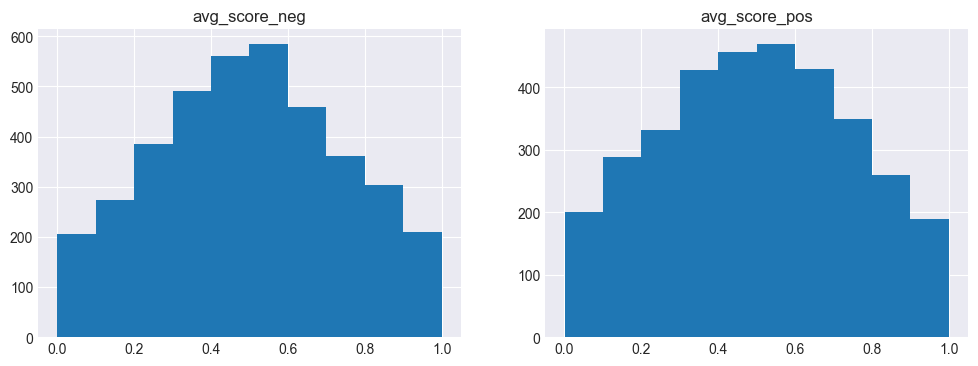

In [38]:
fig, axs = plt.subplots(1, 2, figsize=(12,4))
train_V2["avg_score_neg"].hist(ax=axs[0])
train_V2["avg_score_pos"].hist(ax=axs[1])
axs[0].set_title("avg_score_neg")
axs[1].set_title("avg_score_pos")

Text(0.5, 1.0, 'avg_score_pos')

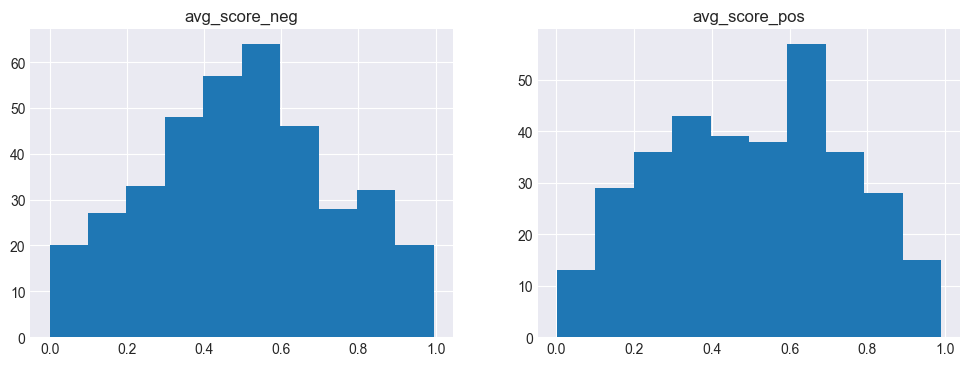

In [39]:
fig, axs = plt.subplots(1, 2, figsize=(12,4))
score["avg_score_neg"].hist(ax=axs[0])
score["avg_score_pos"].hist(ax=axs[1])
axs[0].set_title("avg_score_neg")
axs[1].set_title("avg_score_pos")

In [40]:
# missing percentages when computing the mean
train_V2[["avg_score_pos", "avg_score_neg"]].isnull().mean().sort_values(ascending=False)

avg_score_pos    0.3194
avg_score_neg    0.2332
dtype: float64

We can see that is we compute the mean, we already reduce the number of missings to about 20 - 30 %, which is already an improvement w.r.t. the ~70 % missing values on average per hotel. The fact however that scores for hotel guests are missing may also be a relevant features, so we decide to include that as an additional feature, but in fact we can also count how many hotels have given the score, so 0 will be no hotels (i.e. missing) and then 1 -> 5 for how many hotels have given the score. That way we include the maximum amount of information from the original scores, only neglecting the actual hotels which have given the score which we don't know anyway which is which from the data given and whether or not the hotel labels are consistent between training & score set. That way we can think of imputing an average score to keep those records in the dataset, as we know it was originally missing (i.e. num_score_pos/neg == 0)

In [41]:
# -- assign the missings to a categorical variable
# train_V2["score_pos_missing"] = train_V2["avg_score_pos"].isna()
# train_V2["score_neg_missing"] = train_V2["avg_score_neg"].isna()

# -- count the number of hotels which have given a score, so 0 means it was originally missing for all the hotels
train_V2["num_score_pos"] = (~train_V2[["score1_pos", "score2_pos", "score3_pos", "score4_pos", "score5_pos"]].isnull()).sum(axis=1)
train_V2["num_score_neg"] = (~train_V2[["score1_neg", "score2_neg", "score3_neg", "score4_neg", "score5_neg"]].isnull()).sum(axis=1)

score["num_score_pos"] = (~train_V2[["score1_pos", "score2_pos", "score3_pos", "score4_pos", "score5_pos"]].isnull()).sum(axis=1)
score["num_score_neg"] = (~train_V2[["score1_neg", "score2_neg", "score3_neg", "score4_neg", "score5_neg"]].isnull()).sum(axis=1)

# -- and add it to the categorical variables
#categorical_input_features.extend(["score_pos_missing", "score_neg_missing"])
numerical_input_features = [ ft for ft in numerical_input_features if not ft.startswith("score") ]
numerical_input_features.extend(["avg_score_pos", "avg_score_neg", "num_score_pos", "num_score_neg"])

In [42]:
# -- now drop the original scores from the dataset and from the score dataset
train_V2.drop(columns=["score1_pos", "score2_pos", "score3_pos", "score4_pos", "score5_pos"], inplace=True)
train_V2.drop(columns=["score1_neg", "score2_neg", "score3_neg", "score4_neg", "score5_neg"], inplace=True)

score.drop(columns=["score1_pos", "score2_pos", "score3_pos", "score4_pos", "score5_pos"], inplace=True)
score.drop(columns=["score1_neg", "score2_neg", "score3_neg", "score4_neg", "score5_neg"], inplace=True)

In [43]:
train_V2.head()

,income_am,profit_last_am,profit_am,damage_am,damage_inc,crd_lim_rec,credit_use_ic,gluten_ic,lactose_ic,insurance_ic,spa_ic,empl_ic,cab_requests,married_cd,bar_no,sport_ic,neighbor_income,age,marketing_permit,urban_ic,dining_ic,presidential,client_segment,sect_empl,prev_stay,prev_all_in_stay,divorce,fam_adult_size,children_no,tenure_mts,tenure_yrs,company_ic,claims_no,claims_am,nights_booked,gender,shop_am,shop_use,retired,gold_status,outcome_profit,outcome_damage_inc,outcome_damage_amount,avg_score_pos,avg_score_neg,num_score_pos,num_score_neg
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,227.0,0.0,3201.0,888.0,6.0,15000.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,True,2.0,1.0,28936.0,37.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,3.0,2.0,476.0,40.0,0.0,0.0,0.0,209.0,0.0,0.000000,0.0,0.0,0.0,1791.66,0,0.00,0.652958,0.532814,2,2
1,268.0,16.0,1682.0,0.0,0.0,750.0,0.0,0.0,0.0,1.0,1.0,0.0,7.0,True,3.0,0.0,16674.0,18.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,27.0,2.0,0.0,0.0,0.0,4.0,0.0,0.000000,0.0,0.0,0.0,1672.78,1,829.66,NaN,0.808991,0,1
2,283.0,23.0,1673.0,0.0,0.0,750.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,True,4.0,0.0,32552.0,21.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,95.0,8.0,0.0,0.0,0.0,6.0,0.0,0.000000,0.0,0.0,0.0,1001.40,0,0.00,0.167165,0.118495,2,2
3,227.0,0.0,1685.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,True,8.0,1.0,32252.0,37.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,3.0,2.0,NaN,NaN,0.0,0.0,0.0,4.0,1.0,0.000000,0.0,0.0,0.0,1785.59,0,0.00,NaN,0.889793,0,1
4,4091.0,1028.0,3425.0,785.0,2.0,14000.0,0.0,0.0,1.0,0.0,1.0,0.0,4.0,False,2.0,1.0,29605.0,26.0,0.0,1.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,2.0,0.0,354.0,30.0,0.0,0.0,0.0,3.0,1.0,1454.210627,1.0,0.0,0.0,3140.74,0,0.00,0.410495,0.654370,2,2


### Treatment of the tenure_yrs variable

In the analysis above we also noticed a significant amount of missing values for `tenure_yrs` and `tenure_mts`. What is also striking is that probably both variables express the same quantity, once expressed in months and once in years. Let's visualise that in a scatter plot : 

In [44]:
train_V2[["tenure_mts", "tenure_yrs"]].head()

,tenure_mts,tenure_yrs
Id,,
0,476.0,40.0
1,27.0,2.0
2,95.0,8.0
3,NaN,NaN
4,354.0,30.0


Text(0.5, 0, '12 * tenure_yrs')

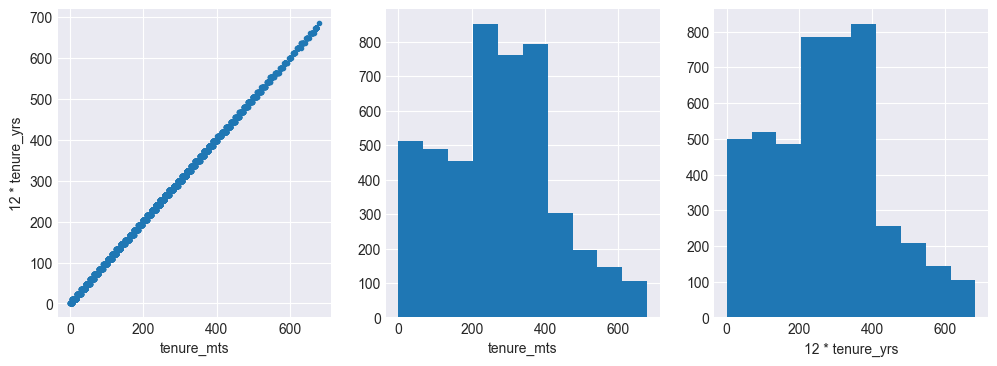

In [45]:
# -- make a scatterplot 
fig, axs = plt.subplots(1, 3, figsize=(12,4))
axs[0].plot(train_V2['tenure_mts'], 12.*train_V2['tenure_yrs'], '.')
axs[0].set_xlabel("tenure_mts")
axs[0].set_ylabel("12 * tenure_yrs")
train_V2["tenure_mts"].hist(ax=axs[1])
axs[1].set_xlabel("tenure_mts")
(12.*train_V2["tenure_yrs"]).hist(ax=axs[2])
axs[2].set_xlabel("12 * tenure_yrs")

First we check if both variables contain the same missings as imputing missing `tenure_mts` from `tenure_yrs` would be a straighforward choice

In [46]:
# -- get the missing values for both
tenure_num_values = train_V2[["tenure_mts", "tenure_yrs"]].isna().sum(axis=1)
# -- test how many only have 1 missing value, so either tenure_mts or tenure_yrs, but not both present or absent
tenure_num_values[tenure_num_values == 1].any()

False

In [47]:
# -- get the missing values for both in the score dataset
tenure_num_values = score[["tenure_mts", "tenure_yrs"]].isna().sum(axis=1)
# -- test how many only have 1 missing value, so either tenure_mts or tenure_yrs, but not both present or absent
tenure_num_values[tenure_num_values == 1].any()

False

No, so `tenure_mts` `tenure_yrs` either both occurr in the dataset, or neither of them. So clearly, both expressing the same variable, once expressed in years, once in months and having established that we can't directly use either one to impute missing values in the other feature, it probably makes no sense to include both. Let's therefore omit the one with the lowest granularity : 

In [48]:
train_V2.drop(columns=['tenure_yrs'], inplace=True)
score.drop(columns=['tenure_yrs'], inplace=True)

numerical_input_features.remove("tenure_yrs")

### Treatment of missing records (instances with missing a lot of information)

We still see that for a large amount of features, there are somewhat 53 missings. Likely, these are records which are not complete. We can clearly see this in the histogram below, which plots a histogram of the the number of missing features per record. 

In [49]:
# number of features
print(f"Number of features train_V2 dataset after transformations so far: {len(train_V2.columns)}")
print(f"Number of features score dataset after transformations so far: {len(score.columns)}")

Number of features train_V2 dataset after transformations so far: 46
Number of features score dataset after transformations so far: 43


Text(0.5, 0, 'Missing features per record for the score dataset')

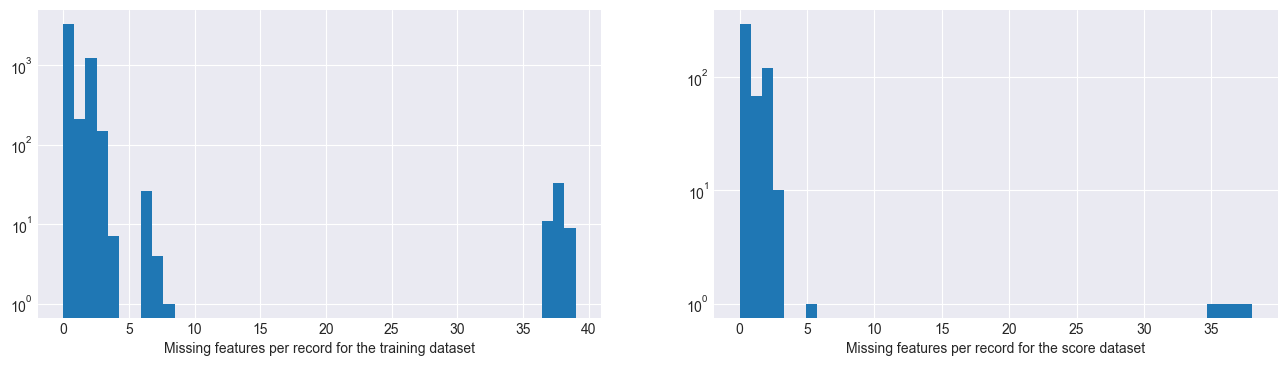

In [50]:
fig, axs = plt.subplots(1, 2, figsize=(16, 4))

# -- a histogram of the amount of missing features per record
train_V2.isnull().sum(axis=1).hist(ax=axs[0], bins=46, log=True)
axs[0].set_xlabel("Missing features per record for the training dataset")

# -- a histogram of the amount of missing features per record in the score dataset 
score.isnull().sum(axis=1).hist(ax=axs[1], bins=46, log=True)
axs[1].set_xlabel("Missing features per record for the score dataset")

We clearly see that for the majority of the records, the number of missing features is less than 10, however for a small amount, we have more than 35 of the features missing. It appears there are 53 such records. It makes sense to delete these rows alltogether. This is a minimal loss of data on a total of 5000 records (1.06 %). 

We see a similar image in the score data. There we have 4 instances. 

We can either place a cut on the number of missing features per record, like so : 

```python
drop_records = train_V2[train_V2.isnull().sum(axis=1) > 35]
print(f"Number of records with > 35 missing features : {drop_records.shape[0]}")
train_V2.drop(index=drop_records.index, inplace=True)
```

or explicitly look at what features are missing, it turns out that : 


In [51]:
train_V2.shape

(5000, 46)

In [52]:
# For a number of instances (53) data seems to be missing for a lot of features (24). These instances may be eliminated from the dataset
instances_missingsData = train_V2[train_V2.loc[:,['company_ic','claims_no','income_am','gold_status','nights_booked','gender','shop_am','retired','fam_adult_size','children_no','divorce','profit_last_am','sport_ic','crd_lim_rec','credit_use_ic','gluten_ic','lactose_ic','insurance_ic','prev_all_in_stay','profit_am','bar_no','age','marketing_permit','urban_ic']].isnull().sum(axis=1) == 24]
print(instances_missingsData.shape)
train_V2 = train_V2.drop(instances_missingsData.index)

(53, 46)


In [53]:
#For a number of instances (4) in score.csv data seems to be missing for a list of features. These will be eliminated from the score set, since comparable instances were removed from the training set
# These are not withheld in the list of clients 
instances_missingsData = score[score.loc[:,['company_ic','claims_no','income_am','gold_status','nights_booked','gender','shop_am','retired','fam_adult_size','children_no','divorce','profit_last_am','sport_ic','crd_lim_rec','credit_use_ic','gluten_ic','lactose_ic','insurance_ic','prev_all_in_stay','profit_am','bar_no','age','marketing_permit','urban_ic']].isnull().sum(axis=1) == 24]
print(instances_missingsData.shape)
score = score.drop(instances_missingsData.index)

(4, 43)


After export of these instances with missing more that 35 features missing, we see that there is data for the following features (other features are NaN):
- `spa_ic` is 23x = 1 (2/21: outcome_damage_ic = 1)
- `empl_ic` is 52x = 0 (12/40: outcome_damage_ic = 1)
- `married_cd` is 53x = false (12/53: outcome_damage_ic = 1)
- `claims_am` is 26x = 0 (6/20: outcome_damage_ic = 1)
- `spa_ic` & `claims_am` & `empl_ic` has data for 6 of these instances 

In [54]:
# -- remaning records
# train_V2.shape
# number of features
print(f"Number of features train_V2 dataset after transformations so far: {len(train_V2.columns)}")
print(f"Number of features score dataset after transformations so far: {len(score.columns)}")

# number of features
print(f"Shape train_V2 dataset after transformations so far: {train_V2.shape}")
print(f"Shape score dataset after transformations so far: {score.shape}")


Number of features train_V2 dataset after transformations so far: 46
Number of features score dataset after transformations so far: 43
Shape train_V2 dataset after transformations so far: (4947, 46)
Shape score dataset after transformations so far: (496, 43)


### Imputation of missing data

In this section we impute the missing data.

In [55]:
missing_rows = train_V2.isnull().sum().sort_values(ascending=False)
print("These are the features for which we still have missing values : ")
missing_rows[missing_rows>0]

These are the features for which we still have missing values : 


avg_score_pos      1544
avg_score_neg      1113
tenure_mts          339
neighbor_income     186
cab_requests         35
presidential         35
dining_ic            35
shop_use             35
dtype: int64

In [56]:
missing_feats_categorical = ['presidential', 'dining_ic', 'shop_use']
missing_feats_continuous = ['tenure_mts', 'neighbor_income', 'cab_requests', 'avg_score_pos', 'avg_score_neg']

In [57]:
missing_features = train_V2.isnull().sum(axis=1).sort_values(ascending=False)  # total missng values, sorted
print("These are the rows which contain missing features : ")
row_idx_missing = missing_features[missing_features>0]
print(row_idx_missing)

These are the rows which contain missing features : 
Id
2504    8
863     7
7       7
2895    7
4286    7
4642    6
627     6
3167    6
3474    6
3727    6
4548    6
3606    6
4940    6
3015    6
3142    6
3845    6
3170    6
1557    6
3564    6
1566    6
1267    6
3166    6
3149    6
1514    6
3192    6
3330    6
4644    6
781     6
2387    6
1782    6
1021    6
605     4
301     4
1409    4
473     4
2618    4
845     4
3510    4
1125    3
3559    3
604     3
3400    3
2910    3
3790    3
2658    3
2285    3
3405    3
739     3
1297    3
1084    3
3226    3
4904    3
1881    3
132     3
3124    3
4303    3
2742    3
4487    3
571     3
1863    3
575     3
172     3
4492    3
1854    3
2509    3
4898    3
2738    3
1547    3
2666    3
2817    3
3100    3
1072    3
3493    3
638     3
1179    3
333     3
1712    3
1626    3
2843    3
4820    3
3864    3
326     3
1192    3
2690    3
1239    3
2693    3
1721    3
668     3
1200    3
2430    3
3880    3
3881    3
3905    3
4579    3
294 

Instead of separating between numerical and categorical values, we will use a **KNNImputer** to make optimal use of possible correlations between the features. **However**, as the KNN technique is sensitive to the scale of the features (it uses a distance based metric), we first have to rescale the features before being able to use a KNNImputer. Most of our features are categorical between 0 and 1, so we'll just use a MinMaxScaler between 0 and 1 to rescale to that fixed range...

In [58]:
# -- first define the min max scaler and apply to the original data
imputer_scaler = MinMaxScaler().set_output(transform="pandas")

# -- set the target features aside as we will apply the imputer to the score as well, which lacks the target features,
#    so only use the input feature for transformation & imputing
train_V2_outcome = train_V2[target_features]
train_V2_scaled = imputer_scaler.fit_transform(train_V2.drop(columns=target_features))
score_scaled = imputer_scaler.transform(score)

# -- next define the imputer having 5 neighbours (default) and uniform weights
imputer_knn = KNNImputer(n_neighbors=5, weights='uniform').set_output(transform="pandas")

# -- apply to the scaled data
train_V2_scaled = imputer_knn.fit_transform(X=train_V2_scaled)
score_scaled = imputer_knn.transform(score)

# -- and apply the inverse transform
train_V2_inv_transformed = imputer_scaler.inverse_transform(train_V2_scaled)
score_inv_transformed = imputer_scaler.inverse_transform(score_scaled) 

# -- interestingly, the set_output(transform="pandas") is not implemented yet on the inverse transform in sklearn,
#    so we will pour the numpy array into a dataframe ourselves (see:  https://github.com/scikit-learn/scikit-learn/issues/27843) 
#    here we put back the outcome variables which we set aside before we fitted the scaler transform
train_V2 = pd.concat( [ pd.DataFrame(train_V2_inv_transformed, columns=train_V2_scaled.columns).set_index(train_V2_scaled.index), train_V2_outcome ], axis=1 )
score = pd.DataFrame(score_inv_transformed, columns=score_scaled.columns).set_index(score_scaled.index)

In [59]:
# we print the unique values in the replaces values for the categorial features in order to 
# test whether they are categorical & no interpolated somehow
for feat_name in missing_feats_categorical:
    print(f"Unique values in {feat_name} replaced missing")
    print(train_V2.loc[row_idx_missing.index, feat_name].unique())

Unique values in presidential replaced missing
[0. 1.]
Unique values in dining_ic replaced missing
[0.  0.2 1. ]
Unique values in shop_use replaced missing
[0.  0.2 1. ]


In [60]:
# ha! so we have a few little bastard slipping through, let's correct !
train_V2.loc[train_V2['dining_ic'] < 0.5,'dining_ic'] = 0.
train_V2.loc[train_V2['shop_use'] < 0.5,'shop_use'] = 0.

score.loc[score['dining_ic'] < 0.5,'dining_ic'] = 0.
score.loc[score['shop_use'] < 0.5,'shop_use'] = 0.

Now finally test whether we still have missing values

In [61]:
missing_rows = train_V2.isnull().sum().sort_values(ascending=False)
print("These are the features for which we still have missing values : ")
missing_rows[missing_rows>0]


print(f"Total amount of missing values in the dataframe : {train_V2.isnull().sum().sum()}")

These are the features for which we still have missing values : 
Total amount of missing values in the dataframe : 0


In [62]:
missing_rows = score.isnull().sum().sort_values(ascending=False)
print("These are the features for which we still have missing values : ")
missing_rows[missing_rows>0]


print(f"Total amount of missing values in the dataframe : {score.isnull().sum().sum()}")

These are the features for which we still have missing values : 
Total amount of missing values in the dataframe : 0


## Anomaly and outlier detection

Now, before moving onwards, we still want to have a look to possible outliers in the data in order to decide what to do with them. Let's start with some simple visualisations like boxplots and histograms to get a feeling for the distribution of the features. 

### Univariate analysis

In [63]:
# -- for the plots
nrows = 6
ncols = 8

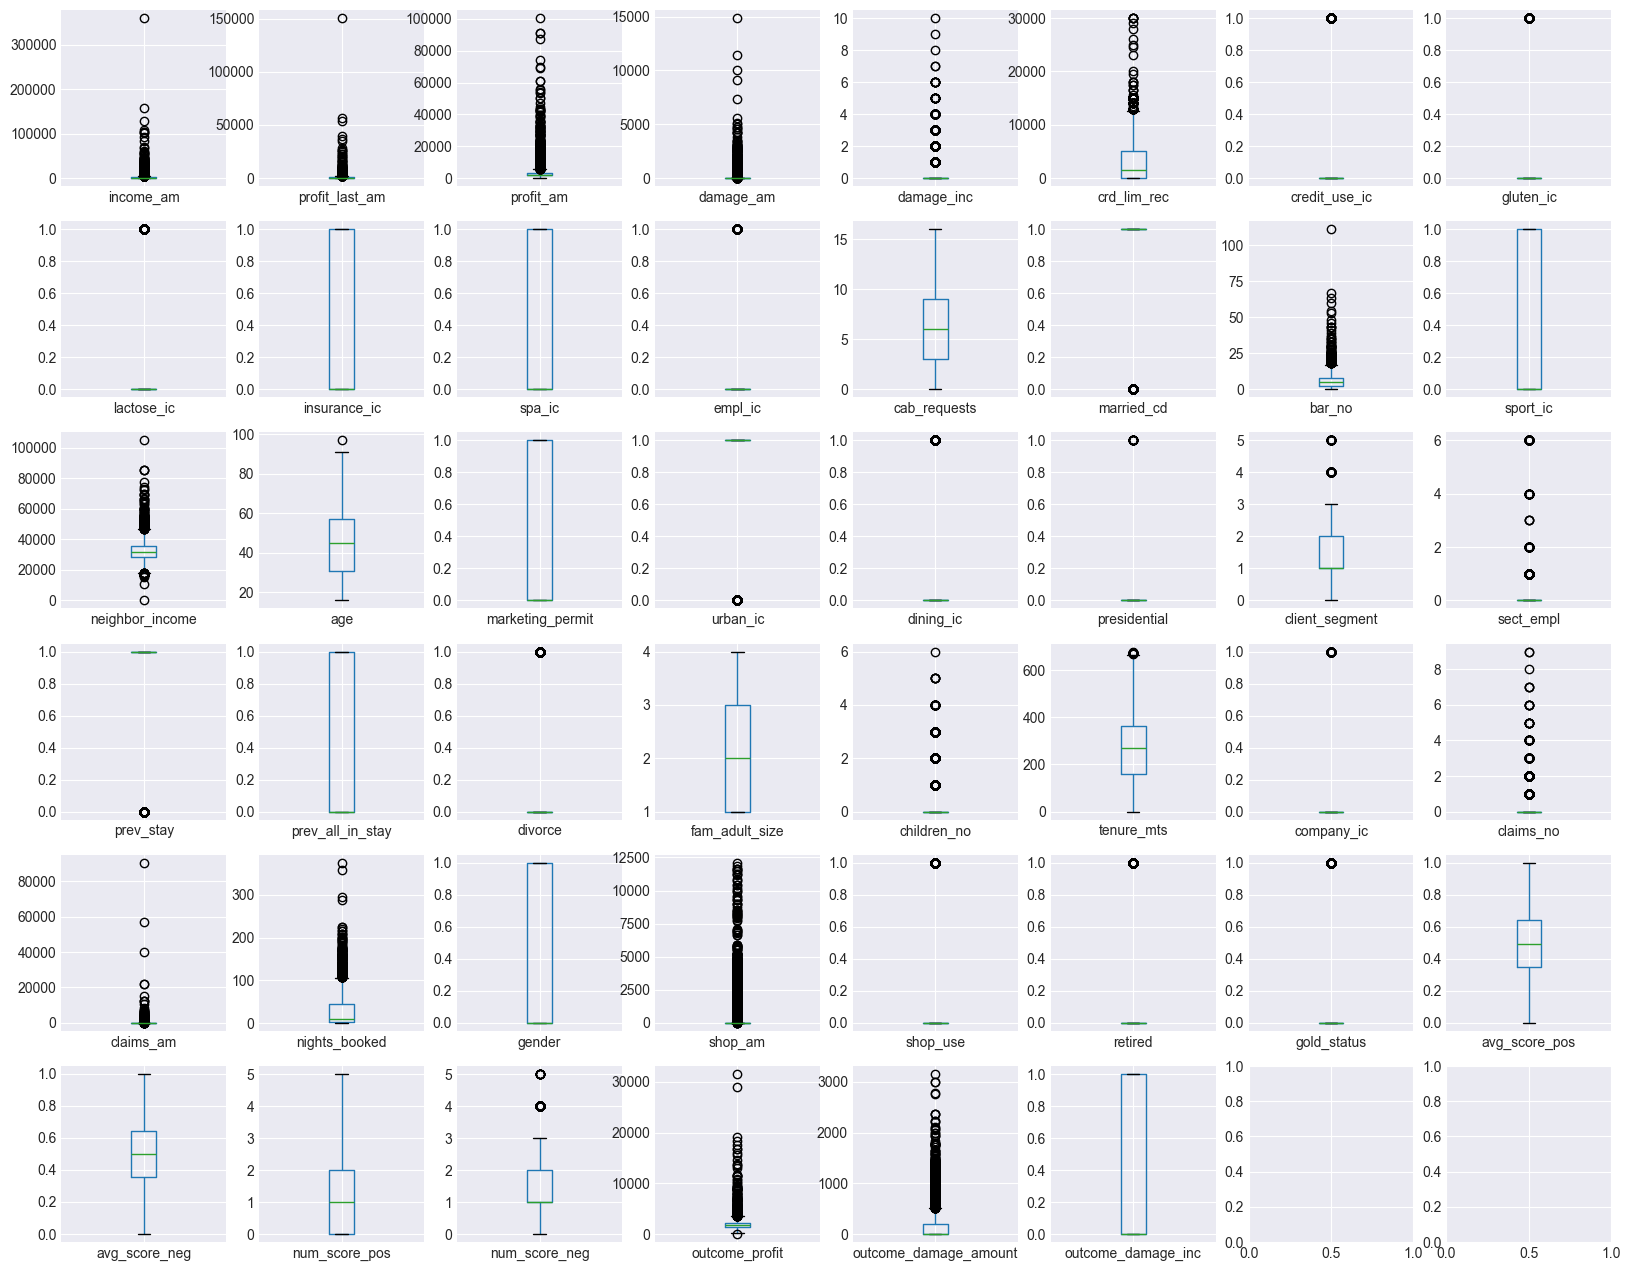

In [64]:
# -- we first make some boxplots for every feature
fig, axs = plt.subplots(nrows, ncols, figsize=(20,16))
for idx, feat_name in enumerate(train_V2.columns):
    row = idx // ncols
    col = idx % ncols
    train_V2.boxplot([feat_name], ax=axs[row][col])

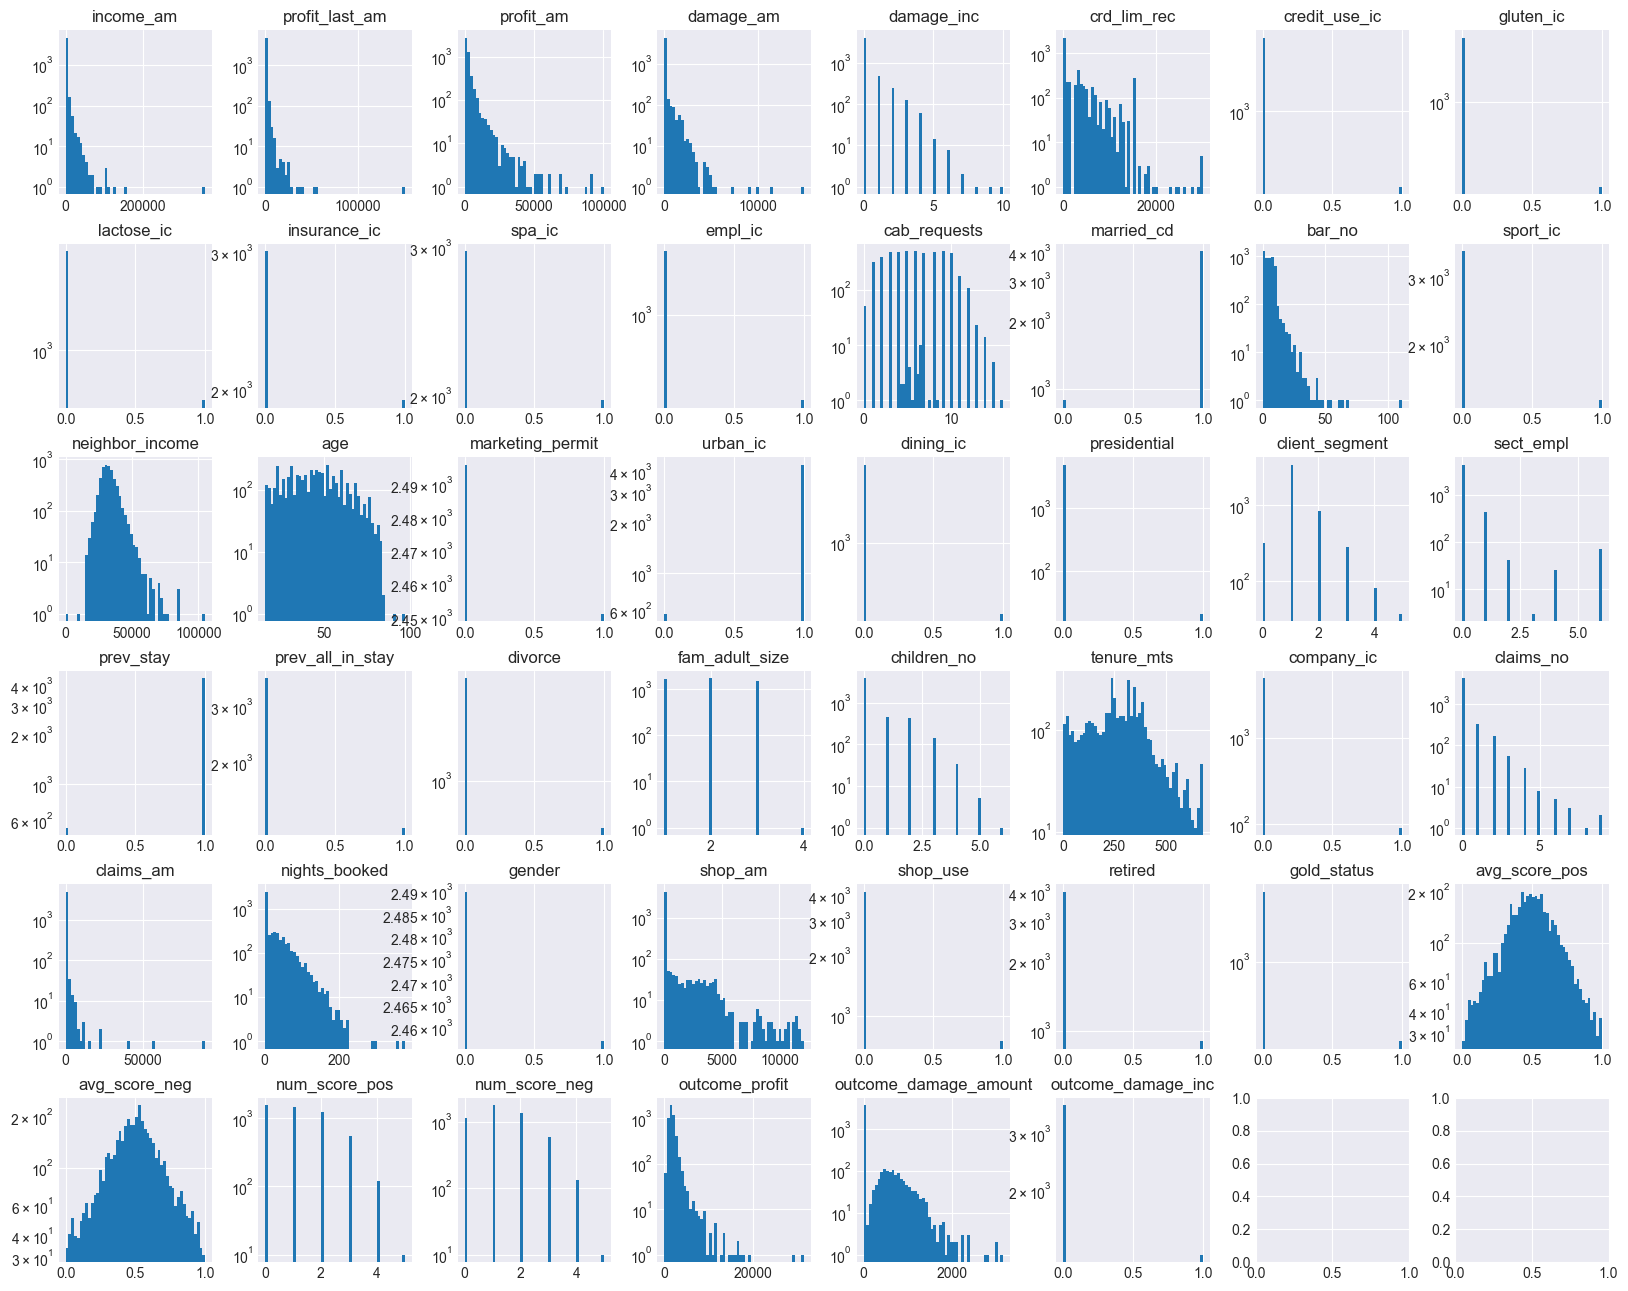

In [65]:
# -- and here we do the same with the histograms
fig, axs = plt.subplots(nrows, ncols, figsize=(20,16))
for idx, feat_name in enumerate(train_V2.columns):
    row = idx // ncols
    col = idx % ncols
    train_V2.hist(feat_name, bins=50, ax=axs[row][col], log=True)

We can already make a couple of interesting observations : 
- There (visually) seem so be some outliers present in the distributions for `income_am`, `profit_last_am`, `damage_am`, `bar_no`, `claims_am`, and `outcome_profit`
- There seem to be some records which show a total number of nights booked (`nights_booked`) at the chain of 0 ! This is rather surprising given that these

Let's look at a few of the outliers : 

In [66]:
train_V2[train_V2['outcome_profit'] > 25000 ]

,income_am,profit_last_am,profit_am,damage_am,damage_inc,crd_lim_rec,credit_use_ic,gluten_ic,lactose_ic,insurance_ic,spa_ic,empl_ic,cab_requests,married_cd,bar_no,sport_ic,neighbor_income,age,marketing_permit,urban_ic,dining_ic,presidential,client_segment,sect_empl,prev_stay,prev_all_in_stay,divorce,fam_adult_size,children_no,tenure_mts,company_ic,claims_no,claims_am,nights_booked,gender,shop_am,shop_use,retired,gold_status,avg_score_pos,avg_score_neg,num_score_pos,num_score_neg,outcome_profit,outcome_damage_amount,outcome_damage_inc
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1979,25327.0,15078.0,30156.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,7.0,1.0,2.0,0.0,50633.0,41.0,1.0,1.0,0.0,0.0,3.0,0.0,1.0,0.0,0.0,3.0,2.0,353.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.399627,0.486164,0.0,0.0,31529.0,0.0,0
3763,360577.0,150537.0,61264.0,4771.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,7.0,1.0,8.0,1.0,48846.0,46.0,0.0,0.0,0.0,0.0,5.0,0.0,1.0,1.0,0.0,3.0,0.0,26.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.332470,0.504499,2.0,2.0,29046.4,1288.2,1


In [67]:
train_V2.drop(1979, inplace=True)
train_V2.drop(3763, inplace=True)

In [68]:
train_V2[train_V2['income_am'] > 150000 ]

,income_am,profit_last_am,profit_am,damage_am,damage_inc,crd_lim_rec,credit_use_ic,gluten_ic,lactose_ic,insurance_ic,spa_ic,empl_ic,cab_requests,married_cd,bar_no,sport_ic,neighbor_income,age,marketing_permit,urban_ic,dining_ic,presidential,client_segment,sect_empl,prev_stay,prev_all_in_stay,divorce,fam_adult_size,children_no,tenure_mts,company_ic,claims_no,claims_am,nights_booked,gender,shop_am,shop_use,retired,gold_status,avg_score_pos,avg_score_neg,num_score_pos,num_score_neg,outcome_profit,outcome_damage_amount,outcome_damage_inc
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
709,157697.0,8.0,31325.0,0.0,0.0,8000.0,0.0,0.0,1.0,1.0,0.0,0.0,3.0,1.0,14.0,0.0,33188.4,45.0,1.0,1.0,0.0,0.0,3.0,0.0,1.0,1.0,0.0,2.0,0.0,242.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.378836,0.26206,3.0,3.0,11451.15,0.0,0


In [69]:
train_V2[train_V2['damage_am'] > 6000 ]

,income_am,profit_last_am,profit_am,damage_am,damage_inc,crd_lim_rec,credit_use_ic,gluten_ic,lactose_ic,insurance_ic,spa_ic,empl_ic,cab_requests,married_cd,bar_no,sport_ic,neighbor_income,age,marketing_permit,urban_ic,dining_ic,presidential,client_segment,sect_empl,prev_stay,prev_all_in_stay,divorce,fam_adult_size,children_no,tenure_mts,company_ic,claims_no,claims_am,nights_booked,gender,shop_am,shop_use,retired,gold_status,avg_score_pos,avg_score_neg,num_score_pos,num_score_neg,outcome_profit,outcome_damage_amount,outcome_damage_inc
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2112,5247.0,1492.0,12741.0,9136.0,7.0,28000.0,0.0,1.0,1.0,1.0,1.0,0.0,3.0,1.0,3.0,0.0,34823.0,46.0,1.0,1.0,0.0,0.0,3.0,0.0,1.0,1.0,0.0,3.0,1.0,575.0,0.0,0.0,0.0,69.0,0.0,0.0,0.0,0.0,0.0,0.026500,0.703839,1.0,1.0,2775.97,1416.26,1
2253,227.0,0.0,1620.0,11394.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,1.0,2.0,0.0,22561.0,52.0,0.0,1.0,0.0,0.0,2.0,2.0,1.0,0.0,0.0,3.0,0.0,358.0,0.0,0.0,0.0,224.0,1.0,0.0,0.0,0.0,0.0,0.326955,0.416902,0.0,0.0,2080.49,733.00,1
2718,227.0,0.0,4808.0,7321.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,1.0,4.0,1.0,28983.0,25.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,3.0,238.0,0.0,0.0,0.0,30.0,1.0,0.0,0.0,0.0,0.0,0.623210,0.522044,0.0,0.0,1353.37,0.00,0
3931,4647.0,1725.0,13871.0,10025.0,9.0,14000.0,1.0,0.0,0.0,1.0,1.0,0.0,13.0,1.0,10.0,0.0,51673.0,35.0,1.0,1.0,0.0,0.0,4.0,6.0,1.0,1.0,0.0,3.0,2.0,308.0,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.312075,0.820847,3.0,3.0,9125.84,1538.22,1
4768,53682.0,61.0,29712.0,14866.0,3.0,30000.0,0.0,0.0,0.0,1.0,0.0,0.0,8.0,1.0,5.0,0.0,34334.0,36.0,1.0,1.0,0.0,0.0,5.0,0.0,1.0,1.0,0.0,3.0,0.0,359.0,0.0,0.0,0.0,44.0,0.0,0.0,0.0,0.0,0.0,0.257344,0.746133,1.0,1.0,2071.03,1046.63,1


In [70]:
train_V2[train_V2['bar_no'] > 100 ]

,income_am,profit_last_am,profit_am,damage_am,damage_inc,crd_lim_rec,credit_use_ic,gluten_ic,lactose_ic,insurance_ic,spa_ic,empl_ic,cab_requests,married_cd,bar_no,sport_ic,neighbor_income,age,marketing_permit,urban_ic,dining_ic,presidential,client_segment,sect_empl,prev_stay,prev_all_in_stay,divorce,fam_adult_size,children_no,tenure_mts,company_ic,claims_no,claims_am,nights_booked,gender,shop_am,shop_use,retired,gold_status,avg_score_pos,avg_score_neg,num_score_pos,num_score_neg,outcome_profit,outcome_damage_amount,outcome_damage_inc
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2512,2341.0,0.0,4922.0,0.0,0.0,3000.0,0.0,0.0,0.0,1.0,0.0,0.0,12.0,0.0,111.0,0.0,39147.0,51.0,1.0,0.0,0.0,0.0,1.0,2.0,0.0,1.0,1.0,2.0,1.0,26.0,0.0,0.0,0.0,4.0,1.0,0.0,0.0,0.0,0.0,0.569805,0.473527,0.0,0.0,1970.7,452.61,1


In [71]:
train_V2[train_V2['claims_am'] > 30000 ]

,income_am,profit_last_am,profit_am,damage_am,damage_inc,crd_lim_rec,credit_use_ic,gluten_ic,lactose_ic,insurance_ic,spa_ic,empl_ic,cab_requests,married_cd,bar_no,sport_ic,neighbor_income,age,marketing_permit,urban_ic,dining_ic,presidential,client_segment,sect_empl,prev_stay,prev_all_in_stay,divorce,fam_adult_size,children_no,tenure_mts,company_ic,claims_no,claims_am,nights_booked,gender,shop_am,shop_use,retired,gold_status,avg_score_pos,avg_score_neg,num_score_pos,num_score_neg,outcome_profit,outcome_damage_amount,outcome_damage_inc
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
818,16991.0,0.0,27679.0,0.0,0.0,12000.0,0.0,0.0,1.0,1.0,1.0,0.0,6.0,1.0,16.0,0.0,26044.0,59.0,1.0,1.0,1.0,0.0,3.0,0.0,0.0,1.0,0.0,1.0,0.0,122.0,0.0,1.0,90587.0,83.0,0.0,0.0,0.0,1.0,0.0,0.456201,0.440444,0.0,0.0,1726.72,829.63,1
2530,227.0,0.0,1620.0,0.0,0.0,11000.0,0.0,0.0,0.0,1.0,0.0,1.0,8.0,1.0,2.0,1.0,29817.0,43.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,3.0,1.0,216.0,0.0,2.0,57222.0,102.0,1.0,0.0,0.0,0.0,0.0,0.641449,0.951726,1.0,1.0,1312.66,0.00,0
4550,286.0,0.0,2959.0,628.0,3.0,2500.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0,1.0,4.0,1.0,34841.0,39.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,2.0,2.0,324.0,0.0,1.0,40265.0,51.0,0.0,0.0,0.0,0.0,0.0,0.821716,0.902322,2.0,2.0,1587.44,0.00,0


So there seems to be a fairly rich person in the dataset with very high income (>200000), but also high `profit_last_am` which seems to be in client segment 5  (a higher segment seems correlated with income (not shown)), so which probably makes sense. We don't think this should necessarily be considered as an outlier. 

### Multivariate analysis

In addition to the univariate analysis above, we also looked at an unsupervised technique for outlier detection, namely **isolation forests**

The output of an Isolation Forest model typically includes the anomaly score for each data point. The anomaly score is a measure of how different or isolated a data point is compared to the rest of the data.

According to the isolationForest more than 10% of the data is an outlier. We believe that this percentage is to high looking at the data.
Therefore we believe that this confirms the conclusion from the univariate analysis

In [ ]:
# Can not handle missing values
# Fitting default isolation forest for anomaly/outlier detection
# Importing the correct class as usual
from sklearn.ensemble import IsolationForest

# Checking which hyperparameters are available
# print(f"Hyperparamerters for IsolationForest class: {IsolationForest().get_params()}")

# Initializing model
if_model = IsolationForest(n_estimators=100, random_state=seed)

# Fitting (only X data, because unsupervised)
X_train_V2 = train_V2.drop(columns=['outcome_profit','outcome_damage_inc','outcome_damage_amount'], inplace=False)
X_alldata = pd.concat([X_train_V2,score])

if_model.fit(X=X_train_V2)

# Predicting on the same data
y_pred_train = if_model.predict(X=X_train_V2)

# Checking frequency table of predicted values
print('Frequency table of predicted values:')
pd.Series(y_pred_train).value_counts(normalize=True)

# Visualisations and exploratory analysis

Now that we have reasonably clean data, let's perform some initial exploratory analysis, correlation plots, etc...

## Imbalance in data?

While a 25% split between classes may not be considered highly imbalanced, it could still lead to potential challenges, especially if the classes are not well-represented. It's important to assess the impact of this class distribution on your specific task and consider techniques like oversampling, undersampling, or using different evaluation metrics to address any imbalance issues. 

In [72]:
p = len(train_V2[train_V2['outcome_damage_inc'] == 1])/len(train_V2) * 100
print('The percentage of hotel guests causing damage is {:.2f}'.format(p))      

The percentage of hotel guests causing damage is 25.56


## Correlation analysis

In [ ]:
# -- this plots the correlation matrix
#    we adjusted the scale and colors a little to make the positive or negative correlations stand out, using the seismic colormap for this
corrmat = train_V2.corr(numeric_only=True)
plt.figure(figsize=(16, 12))
sns.heatmap(corrmat, vmin=-1, vmax=1, center=0, cmap="seismic",  linewidth=.5)

In [ ]:
# Checking univariate distribution of the revenue
sns.displot(train_V2['outcome_profit'] - train_V2['outcome_damage_amount']);  # With seaborn for a change
plt.xticks(rotation=45); # Rotating x labels

In [ ]:
# But I guess a scatter plot would've done well also

plt.scatter(x = range(0, 0 + len(train_V2)),y=train_V2['outcome_profit'] - train_V2['outcome_damage_amount'], alpha=0.5);  # alpha=0.5 makes it a bit see through
plt.xlabel('Id');
plt.ylabel('revenue');
plt.title('Alternative: scatter plot');
plt.show() 

In [ ]:
# Plotting
x = 'neighbor_income'
plt.figure(figsize=(8, 6))
plt.scatter(x=train_V2[x], y=train_V2['outcome_profit']);
plt.scatter(x=train_V2[x], y=train_V2['outcome_damage_amount']);
plt.title('profit and damage');
plt.xlabel(x);

In [ ]:
# Scatterplot matrix (might take a while)
plot_cols = ['outcome_damage_inc', 'income_am', 'profit_last_am', 'profit_am', 'damage_am', 'damage_inc', 'crd_lim_rec']
sns.pairplot(train_V2[plot_cols], height=2.5);

# Model training


Goal of the What do we need to predict? Is it available as outcome in our data
1. the revenue per client (= profit - damage)
    - needs to be calculated
2. predict which clients will cause damage
    - outcome_damage_inc
3. predict the amount of damage fot those who will cause damage / wreak havoc
    - outcome_damage_amount

Calculate revenue


## TODO

- es trainen op apart amount profit & damage, maar ook es op verschil (revenue)
- testen of weglaten van de outliers iets oplevert

## verdeling

- Bino : GBM
- Marijke : RF
- Dries : SVR/SVC

## Gradient Booster Regression

In this section we will attempt to use a gradient booster regression to explain the profit & damage. 

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
GradientBoostingRegressor().get_params()

### Train - test split

In [ ]:
target_features

In [ ]:
train_V2.columns

We do a train test split with a 20 % holdout for final evaluation, we will use K-fold cross-validation on the train set. Since here we are applying a tree based method, no rescaling is needed. 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train_V2.drop(target_features, axis=1), 
                                                    train_V2["outcome_profit"],  
                                                    test_size=0.2,
                                                    shuffle=True, 
                                                    random_state=seed) 

Below we play around manually with the GradientBoostingRegressor parameters. It was noticed that
- including a limit to the `max_leaf_nodes` does increase test R2, so will include this in hyperparam search
- we have to choose the `n_estimators` (# boosting stages) fairly large it seems, while still keeping learning rate to relatively high value, strange, will optimize further in the hyperparam search

In [ ]:
gbm_params = {
    'n_estimators': 600,  # number of boosting stages to perform
    'subsample': 1.0,     # 1.0 leads to reduction in variance and increase in bias
    'max_depth': 3,       # limiting the max depth to the default of 3 seems to improve the test R2
    'min_samples_split': 2, # default
    'min_samples_leaf': 1,  # default
    'max_leaf_nodes': 8, # limiting the max number of leaf nodes does increase performance !! improvement of test R2 vs using None
    'learning_rate': 0.1, # default
    'ccp_alpha': 0.0}  # default is 0.0

gbm = GradientBoostingRegressor(loss='squared_error', random_state=seed, **gbm_params) 
gbm.fit(X=X_train, y=y_train) 

# Step 4 - Getting predictions
gbm_preds = gbm.predict(X=X_test)
gbm_preds_train = gbm.predict(X=X_train)

test_R2 = gbm.score(X=X_test, y=y_test)
train_R2 = gbm.score(X=X_train, y=y_train)

# Print R2 results
print(f'Train R2: {train_R2:.3}')
print(f'Test R2: {test_R2:.3}')

We noticed a few things : 
- leaving out the 2 outliers in the `outcome_profit` of > 25000 results in a significant increase in Test R2 (0.85 vs. 0.81), so perhaps it is better to leave those values out of the training as it is not certain how representave they are for the final scoring dataset. We can revisit this argument after the hyperparameter scan. 
- we also tried log-transforming the `outcome_profit` feature before fitting (`np.log(1+train_V2["outcome_profit"])`) in order to test whether this would give any improvement, given the fairly skew distribution of the `outcome_profit`values. This resulting in drastically lower test R2 (and also train R2) of 0.65 and 0.86 respectively, so we will not apply any log-transformation here. 

In [ ]:
# -- let's make a quick plot of the results for the training & test dataset
axis_range = [0, 25000]
fig, axs = plt.subplots(1, 2, figsize=(16, 6))
axs[0].plot(gbm_preds_train, y_train, '.')
axs[0].set_title(f"Training dataset (Train R2 = {train_R2:.3})")
axs[0].set_ylim(axis_range)
axs[0].set_xlim(axis_range)

axs[1].plot(gbm_preds, y_test, '.')
axs[1].set_title(f"Test dataset (Test R2 = {test_R2:.3})")
axs[1].set_ylim(axis_range)
axs[1].set_xlim(axis_range)

Let's now try to optimise the manually tweaked hyperparameter further in an automated way using a RandomisedSearchCV

In [ ]:
# -- first chooe how many hyper parameters to randomly sample
n_hyperparam_sample = 200

In [ ]:
# Putting them all in a dictionary
random_grid = {
    'n_estimators': [ int(x) for x in np.linspace(start=200, stop=1000, num=9)],
    'max_depth': [int(x) for x in np.linspace(1, 10, num=10)],
    'min_samples_split': [2, 5, 10, 30],
    'min_samples_leaf': [1, 2, 4, 10, 30],
    'max_leaf_nodes': [int(x) for x in np.linspace(2, 20, num=19)],
    'learning_rate': [0.01, 0.02, 0.05, 0.08, 0.1],
    }

# currently leave out those : 
#'max_features':  [0.1, 0.3, 0.5, 0.7, 0.9] # not using this one... best leave at default !
#'subsample': [0.4, 0.6, 0.8, 1],


#min_impurity_decrease: 0.0,
# Instantiate base model to tune (RF with default settings, altough you can fix parameters here if you want)
gbr = GradientBoostingRegressor()

# Random search of parameters, using 3 fold cross validation, across 500 different hyperparameter combinations, and use all available cores
rf_hyperparam_tuning_random = RandomizedSearchCV(estimator=gbr, 
                                                 param_distributions=random_grid, 
                                                 n_iter=n_hyperparam_sample,   # Amount of hyperparameter values to sample
                                                 cv=KFold(n_splits=5, shuffle=True, random_state=seed), # setting the shuffle to True here ... 
                                                 verbose=2, # to print some outputs
                                                 random_state=seed, 
                                                 n_jobs=-1)

# Fit the random search by sampling hyperparameters from our grid, then fitting each model for each CV fold, aggregating results
rf_hyperparam_tuning_random.fit(X=X_train, y=y_train)

# Now you can access the fitted object, e.g. get best_params_
print(f"Optimally found RF hyperparams after this random search: {rf_hyperparam_tuning_random.best_params_}")

## Random forest
### Model to predict revenue per client 

Goal of the What do we need to predict? 
1. the revenue per client (= profit - damage)

We could fit the revenue by fitting the profit and by fitting the damage and subtracting them. Or we could calculate the revenue in the training set and fit the revenue as such.

When you need to predict a difference, you would typically predict each term individually and then calculate the difference between the predicted values. By predicting each term separately, you can estimate the values of the components involved in the difference and then determine the overall difference based on these predictions. This approach helps in forecasting the outcome of the difference by considering the predicted values of its individual components.

Below we have looked at the R2 result for an RF-model on the revenue and an RF-model on the profit

In [73]:
# The outcome to maximize is profit - damage

# don't assign to dataframe just yet ???
train_V2['revenue'] = train_V2['outcome_profit'] - train_V2['outcome_damage_amount']

In [74]:
train_V2.to_csv('..\\train_v2_prep_without_outliers.csv')
score.to_csv('..\\score_prep_without_outliers.csv')

In [75]:
# Making train-test set split and selecting target = outcome_profit
#
# A train split of 20% is chosen to balance between having enough data to train the model effectively and having a sufficient amount of data to evaluate its performance.
#   With a larger training set (80%), the model can learn more patterns and relationships in the data, potentially leading to better performance.
#   On the other hand, a smaller test set (20%) allows for a more robust evaluation of the model's generalization capabilities.

X_train, X_test, y_train, y_test = train_test_split(train_V2.drop(['outcome_damage_amount','outcome_damage_inc','outcome_profit','revenue'], axis=1), # features DF
#X_train, X_test, y_train, y_test = train_test_split(train_V2.drop(['outcome_damage_amount','outcome_damage_inc','outcome_profit','revenue','score_pos','score_neg','not_null_pos_columns','not_null_neg_columns'], axis=1), # features DF
                                                    train_V2['outcome_profit'],   # target DF/series
                                                    test_size=0.2, 
                                                    shuffle=True,  
                                                    random_state=seed)  

# Defining candidate grid to sample from (RandomizedSearchCV will sample from it)
n_estimators = [int(x) for x in np.linspace(start=150, stop=300, num=6)]  # list comprehension because we want integers!
max_depth = [int(x) for x in np.linspace(start=5, stop=85, num=8)]
max_depth.append(None)  # adding 'None' option as well
max_features = [0.7, 0.8, 0.9, 0.98]
min_samples_split = [4, 5, 6, 8]
min_samples_leaf = [2, 3, 4,6]
bootstrap = [True]
hyperparam_grid = {'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf,
                   'bootstrap': bootstrap}

# Define data splitter to be used in the search
n_folds = 5
kfold = KFold(n_splits=n_folds, shuffle=True, random_state=seed)

# Define amount of hyperparameter tuning combinations to sample
n_hyperparams_sample = 100

# Defining model to apply random search CV hyperparam tuning on
# outcome_profit is continuous, therefore a regressor needs to be applied
rfr = RandomForestRegressor()

# Initializing random search CV object
rf_hyperparam_tuning_random = RandomizedSearchCV(estimator=rfr, 
                                          param_distributions=hyperparam_grid, 
                                          n_iter=n_hyperparams_sample, 
                                          cv=kfold,
                                          verbose=2, 
                                          random_state=seed, 
                                          n_jobs=-1)

# Fit the random search by sampling hyperparameters from our grid, then fitting each model for each CV fold, aggregating results
rf_hyperparam_tuning_random.fit(X=X_train, y=y_train)

print('Optimally found RF hyperparams after this random search: \n{}' .format(rf_hyperparam_tuning_random.best_params_))

# Refitting the optimal model on the whole training dataset
rf_profit_best = rf_hyperparam_tuning_random.best_estimator_
rf_profit_best.fit(X=X_train, y=y_train)

# Getting predictions on train and test set
rf_profit_best_y_train_pred = rf_profit_best.predict(X=X_train)
rf_profit_best_y_test_pred = rf_profit_best.predict(X=X_test)

# Checking the score: R2 manually
print('Train R2: %.3f' % rf_profit_best.score(X=X_train, y=y_train))
print('Test R2: %.3f' % rf_profit_best.score(X=X_test, y=y_test))


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Optimally found RF hyperparams after this random search: 
{'n_estimators': 210, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 0.98, 'max_depth': None, 'bootstrap': True}
Train R2: 0.942
Test R2: 0.808


In [76]:
#pickle.dump(rf_profit_best, open('RF_model_profit.pkl','wb'))
pickle.dump(rf_profit_best, open('RF_model_profit_without_outliers.pkl','wb'))

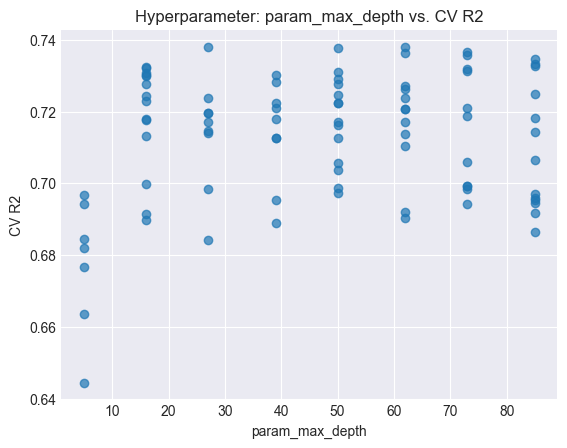

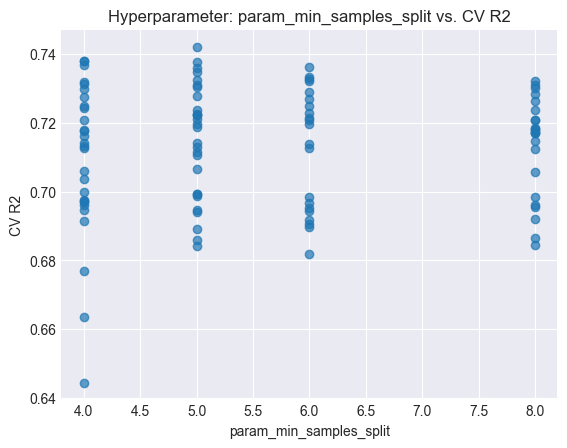

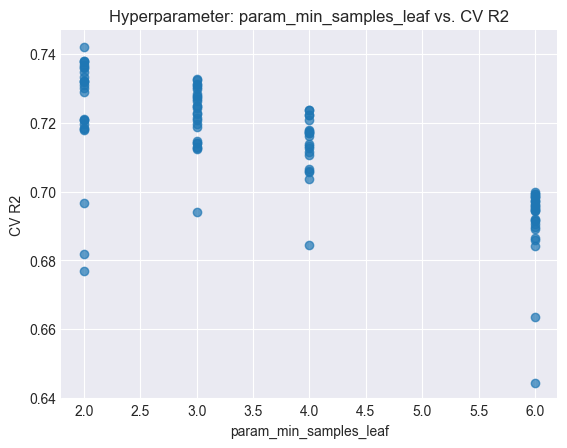

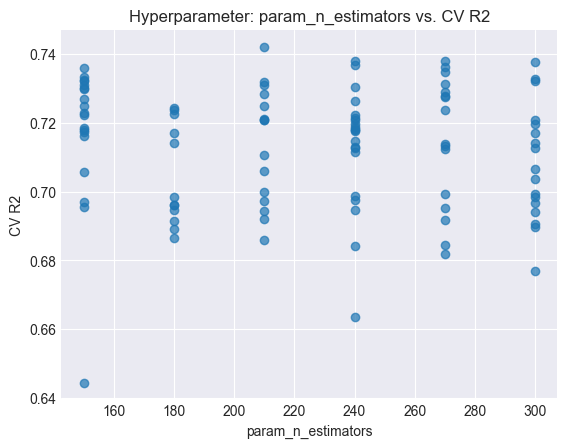

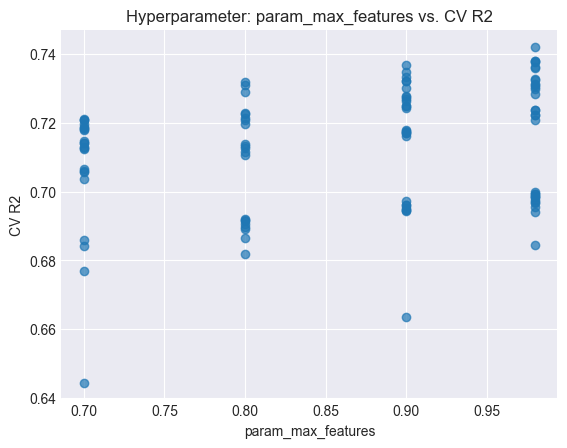

In [77]:
# Extracting hyperparameter tuning results and checking
rf_cv_res = pd.DataFrame(rf_hyperparam_tuning_random.cv_results_)

# Scatter plot of selection of hyperparams vs performance
plot_hyperparams = ['param_max_depth', 'param_min_samples_split', 'param_min_samples_leaf', 'param_n_estimators', 'param_max_features']  
# in the .cv_results_ there is always a 'param_' prefix!

for param in plot_hyperparams:
    plt.figure(); # This command will help in the plots not 'falling' on top of each other ;)
    plt.scatter(x=rf_cv_res[param], y=rf_cv_res['mean_test_score'], alpha=0.7); # alpha to get some opacity
    plt.xlabel(param);
    plt.ylabel('CV R2')
    plt.title(f"Hyperparameter: {param} vs. CV R2")

From these plots we see that not all params in the RanomizedGridSearch seem to have an impact on the performance of the RandomForestRegressor.  
However performances gets better for trees with a higher depth.  
The model also shows better performance for a higher percentage for max_features.


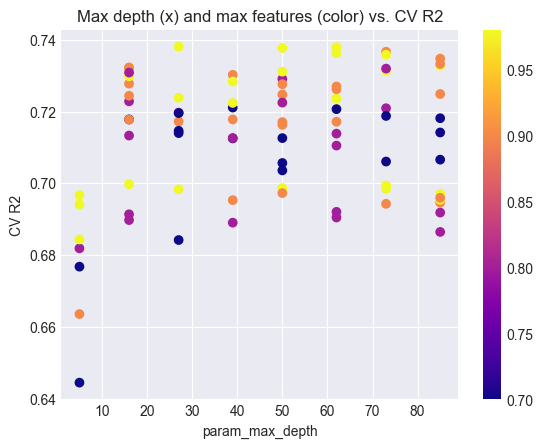

In [78]:
# Plotting hyperparameter vs. performance: more complex plots
plt.scatter(x=rf_cv_res['param_max_depth'], 
            y=rf_cv_res['mean_test_score'], 
            c=rf_cv_res['param_max_features'], # c argument allows to color according to param_n_estimators
            cmap='plasma');  # This makes the color non-dull
plt.colorbar();  # adds the bar on the right
plt.xlabel('param_max_depth');
plt.ylabel('CV R2');
plt.title('Max depth (x) and max features (color) vs. CV R2');

#### Learning curve

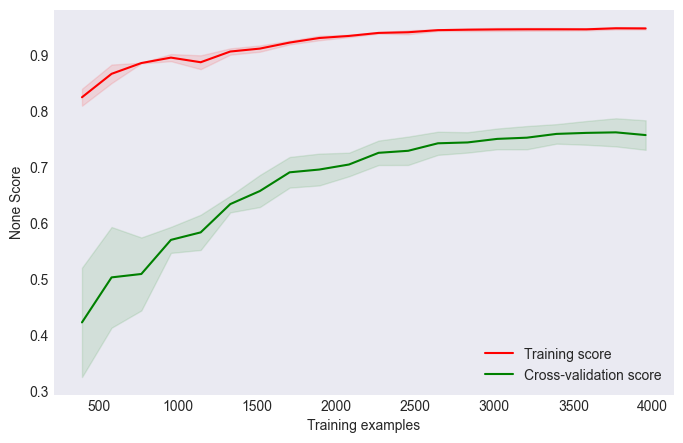

In [79]:
# The learning_curve for our mode
cuf.plot_learning_curve(model=rf_profit_best, 
                    X=train_V2.drop(['outcome_damage_amount','outcome_damage_inc','outcome_profit','revenue'], axis=1), 
                    y=train_V2['outcome_profit'], 
                    cv=5, 
                    num_show=20)
plt.show()

### Model to predict the amount of damage per client

Goal of the What do we need to predict? Is it available as outcome in our data?

3. predict the amount of damage fot those who will cause damage / wreak havoc
    - outcome_damage_amount

In [80]:
# Making train-test set split (Note: we're taking 30% test set size here instead of 20%)
X_train, X_test, y_train, y_test = train_test_split(train_V2.drop(['outcome_damage_amount','outcome_damage_inc','revenue','outcome_profit'], axis=1), # features DF
                                                    train_V2['outcome_damage_amount'],   # target DF/series
                                                    test_size=0.3, # 30% as test or validation set (who cares about the exact names)
                                                    shuffle=True,  # This shuffles the data! (Important)
                                                    random_state=seed)  # setting seed for consistent results

In [81]:
# Defining candidate grid to sample from (RandomizedSearchCV will sample from it)
# n_estimators = [int(x) for x in np.linspace(start=100, stop=300, num=10)] 
# max_features = [int(x) for x in np.linspace(start=5, stop=50, num=8)] 
# max_depth = [int(x) for x in np.linspace(start=2, stop=100, num=10)]
# max_depth.append(None)  # adding 'None' option as well
# min_samples_split = [2, 5, 10]
# min_samples_leaf = [1, 2, 4, 10]

n_estimators = [int(x) for x in np.linspace(start=150, stop=300, num=6)] 
max_depth = [int(x) for x in np.linspace(start=5, stop=85, num=8)]
max_depth.append(None)  # adding 'None' option as well
max_features = [0.7, 0.8, 0.9, 0.98]
min_samples_split = [4, 5, 6, 8]
min_samples_leaf = [2, 3, 4,6]

bootstrap = [True, False]
hyperparam_grid = {'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf,
                   'bootstrap': bootstrap}

# Define data splitter to be used in the search
n_folds = 5
kfold = KFold(n_splits=n_folds, shuffle=True, random_state=seed)

# Define amount of hyperparameter tuning combinations to sample
n_hyperparams_sample = 100

# Defining model to apply random search CV hyperparam tuning on
rf = RandomForestRegressor()

# Initializing random search CV object
rf_hyperparam_tuning_random = RandomizedSearchCV(estimator=rf, 
                                          param_distributions=hyperparam_grid, 
                                          n_iter=n_hyperparams_sample, 
                                          cv=kfold,
                                          verbose=2, 
                                          random_state=seed, 
                                          n_jobs=-1)

# Fit the random search by sampling hyperparameters from our grid, then fitting each model for each CV fold, aggregating results
rf_hyperparam_tuning_random.fit(X=X_train, y=y_train)

print('Optimally found RF hyperparams after this random search: \n{}' .format(rf_hyperparam_tuning_random.best_params_))

# Refitting the optimal model on the whole training dataset
rf_damageAmount = rf_hyperparam_tuning_random.best_estimator_
rf_damageAmount.fit(X=X_train, y=y_train)

# Getting predictions on train and test set
rf_damageAmount_best_y_train_pred = rf_damageAmount.predict(X=X_train)
rf_damageAmount_best_y_test_pred = rf_damageAmount.predict(X=X_test)


# Checking accuracy manually
print('Train R2: %.3f' % rf_damageAmount.score(X=X_train, y=y_train))
print('Test R2: %.3f' % rf_damageAmount.score(X=X_test, y=y_test))

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Optimally found RF hyperparams after this random search: 
{'n_estimators': 240, 'min_samples_split': 5, 'min_samples_leaf': 6, 'max_features': 0.98, 'max_depth': 5, 'bootstrap': True}
Train R2: 0.237
Test R2: 0.040


In [82]:
pickle.dump(rf_damageAmount, open('RF_model_damage_amount_without_outliers.pkl','wb'))
#pickle.dump(rf_damageAmount, open('RF_model_damage_amount.pkl','wb'))

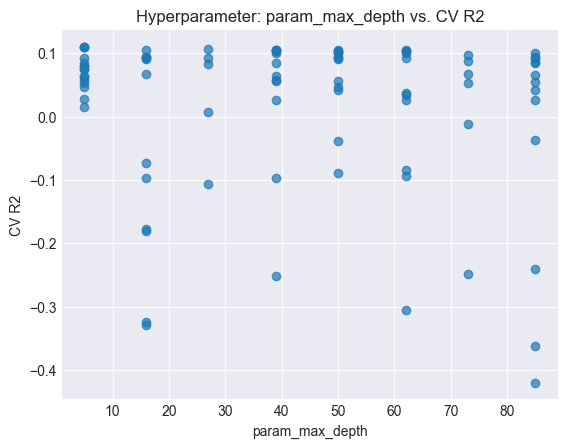

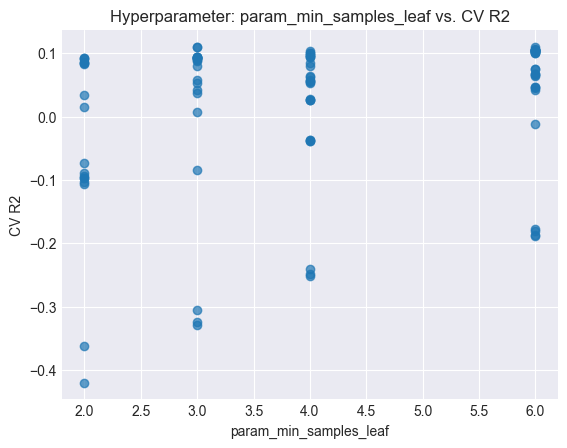

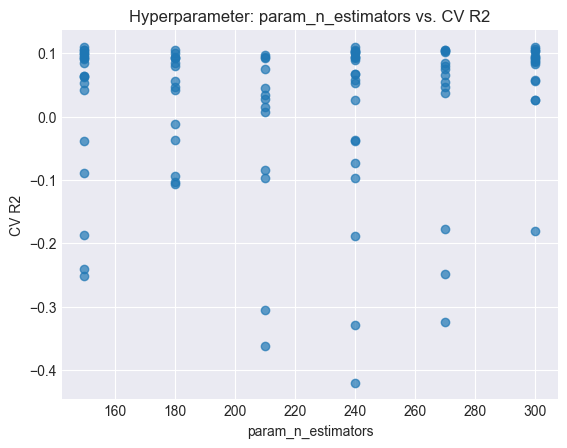

In [83]:
# Extracting hyperparameter tuning results and checking
rf_cv_res = pd.DataFrame(rf_hyperparam_tuning_random.cv_results_)

# Scatter plot of selection of hyperparams vs performance
plot_hyperparams = ['param_max_depth', 'param_min_samples_leaf', 'param_n_estimators']  
# in the .cv_results_ there is always a 'param_' prefix!

for param in plot_hyperparams:
    plt.figure(); # This command will help in the plots not 'falling' on top of each other ;)
    plt.scatter(x=rf_cv_res[param], y=rf_cv_res['mean_test_score'], alpha=0.7); # alpha to get some opacity
    plt.xlabel(param);
    plt.ylabel('CV R2')
    plt.title(f"Hyperparameter: {param} vs. CV R2")

### Model to predict which clients will cause damage

Goal of the What do we need to predict? Is it available as outcome in our data

2. predict which clients will cause damage
    - outcome_damage_inc


Train-test set split for output = output_damage_inc

In [102]:
# Making train-test set split (Note: we're taking 30% test set size here instead of 20%)
X_train, X_test, y_train, y_test = train_test_split(train_V2.drop(['outcome_damage_amount','outcome_damage_inc','revenue','outcome_profit'], axis=1), # features DF
                                                    train_V2['outcome_damage_inc'],   # target DF/series
                                                    test_size=0.4, # 30% as test or validation set (who cares about the exact names)
                                                    shuffle=True,  # This shuffles the data! (Important)
                                                    random_state=seed)  # setting seed for consistent results


In [85]:
# Defining candidate grid to sample from (RandomizedSearchCV will sample from it)
# n_estimators = [int(x) for x in np.linspace(start=100, stop=500, num=5)]
# max_features = [int(x) for x in np.linspace(start=5, stop=150, num=20)] 
# max_depth = [int(x) for x in np.linspace(start=2, stop=40, num=10)]
# max_depth.append(None)  # adding 'None' option as well
# min_samples_split = [2, 5, 10]
# min_samples_leaf = [1, 2, 4, 10]

n_estimators = [int(x) for x in np.linspace(start=150, stop=300, num=6)] 
max_depth = [int(x) for x in np.linspace(start=5, stop=85, num=8)]
max_depth.append(None)  # adding 'None' option as well
max_features = [0.7, 0.8, 0.9, 0.98]
min_samples_split = [4, 5, 6, 8]
min_samples_leaf = [2, 3, 4,6]

bootstrap = [True, False]
hyperparam_grid = {'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf,
                   'bootstrap': bootstrap}

# Define data splitter to be used in the search
n_folds = 5
kfold = KFold(n_splits=n_folds, shuffle=True, random_state=seed)

# Define amount of hyperparameter tuning combinations to sample
n_hyperparams_sample = 100

# Defining model to apply random search CV hyperparam tuning on
rf = RandomForestClassifier()

# Initializing random search CV object
rf_hyperparam_tuning = RandomizedSearchCV(estimator=rf, 
                                          param_distributions=hyperparam_grid, 
                                          n_iter=n_hyperparams_sample, 
                                          cv=kfold,
                                          verbose=2, 
                                          random_state=seed, 
                                          n_jobs=-1)

# Executing / fitting the random search 
rf_hyperparam_tuning.fit(X=X_train, y=y_train)
print('Optimal hyperparameter values according to our random search: \n{}' .format(rf_hyperparam_tuning.best_params_))

# Refitting the optimal model on the whole training dataset
rf_damageInd = rf_hyperparam_tuning.best_estimator_
rf_damageInd.fit(X=X_train, y=y_train)

# Getting predictions on train and test set
rf_damageInd_y_train_pred = rf_damageInd.predict(X=X_train)
rf_damageInd_y_test_pred = rf_damageInd.predict(X=X_test)

# Checking accuracy manually
print('Train accuracy of the refitted model: %.3f' % rf_damageInd.score(X=X_train, y=y_train))
print('Test accuracy of the refitted model: %.3f' % rf_damageInd.score(X=X_test, y=y_test))

# Classification report 
target_names = ['no damage', 'damage']
print(classification_report(y_true=y_test, y_pred=rf_damageInd_y_test_pred, target_names=target_names))

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Optimal hyperparameter values according to our random search: 
{'n_estimators': 300, 'min_samples_split': 8, 'min_samples_leaf': 6, 'max_features': 0.8, 'max_depth': 27, 'bootstrap': True}
Train accuracy of the refitted model: 0.888
Test accuracy of the refitted model: 0.738
              precision    recall  f1-score   support

   no damage       0.76      0.95      0.84      1459
      damage       0.50      0.14      0.22       519

    accuracy                           0.74      1978
   macro avg       0.63      0.54      0.53      1978
weighted avg       0.69      0.74      0.68      1978



In [86]:
pickle.dump(rf_damageInd, open('..\\RF_model_damage_inc_without_outliers.pkl','wb'))
#pickle.dump(rf_damageInd, open('..\\RF_model_damage_inc.pkl','wb'))

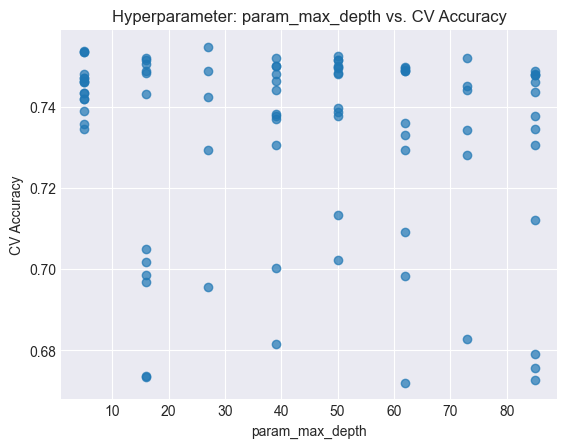

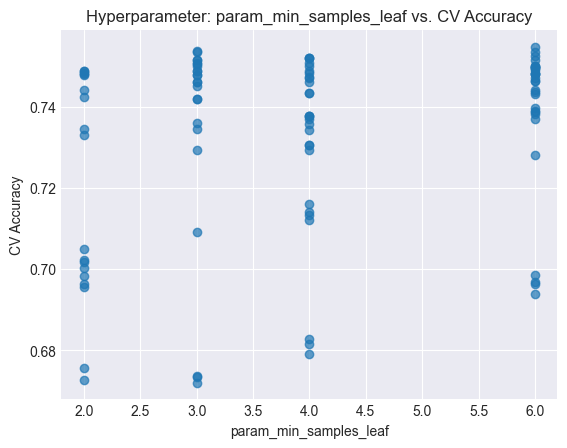

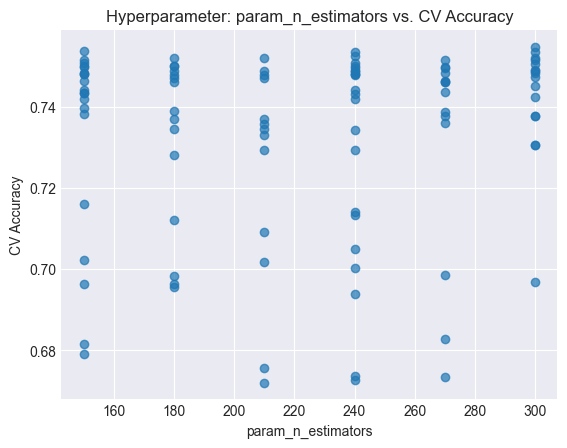

In [87]:
# Extracting hyperparameter tuning results and checking
rf_cv_res = pd.DataFrame(rf_hyperparam_tuning.cv_results_)

# Scatter plot of selection of hyperparams vs performance
plot_hyperparams = ['param_max_depth', 'param_min_samples_leaf', 'param_n_estimators']  
# in the .cv_results_ there is always a 'param_' prefix!

for param in plot_hyperparams:
    plt.figure(); # This command will help in the plots not 'falling' on top of each other ;)
    plt.scatter(x=rf_cv_res[param], y=rf_cv_res['mean_test_score'], alpha=0.7); # alpha to get some opacity
    plt.xlabel(param);
    plt.ylabel('CV Accuracy')
    plt.title(f"Hyperparameter: {param} vs. CV Accuracy")

#### Probability of damage


Setting Decision Threshold

In the context of our problem we want to select the applicants that will generate the highest revenue. Whether they do or do not cause damage is less important, therefore we will look at precision rather than recall. Precision measures the accuracy of the selected cases, specifically the proportion of selected cases that are relevant (in this case, generating high revenue).

For models that output a continuous probability-like value (basically: most models except SVM), the predict function really just applies a cut-off of 0.5 to the predicted values returned from the model. In cases like this where there is class imbalance, probabilities will only start to deviate from the imbalanced 30% once the model has good separation of classes. In the absence of that, 0.5 is definitely not the best cutoff. This leads to e.g. a recall of 0.0. You will in fact see that many of the algorithms in this practical get both precision and recall of the expensive class equal to 0, which means that no instance is classified as expensive with the default cutoff of 0.5.

In [88]:
# Decision cutoff/threshold tuning for classification models
# Choose a cutoff/threshold value
cutoff = 0.15

# Refitting an RF with the tuned hyperparameters from the previous cell
print(f"Checking parameters of rf_damageInd: {rf_damageInd}")

# Getting performances & classification report
print('Train accuracy: %.3f' % rf_damageInd.score(X=X_train, y=y_train))
print('Test accuracy: %.3f' % rf_damageInd.score(X=X_test, y=y_test))
target_names = ['No damage', 'Damage']
print(classification_report(y_test, (rf_damageInd.predict_proba(X=X_test)[:, 1] > cutoff), target_names=target_names))

Checking parameters of rf_damageInd: RandomForestClassifier(max_depth=27, max_features=0.8, min_samples_leaf=6,
                       min_samples_split=8, n_estimators=300)
Train accuracy: 0.888
Test accuracy: 0.738
              precision    recall  f1-score   support

   No damage       0.85      0.29      0.44      1459
      Damage       0.30      0.86      0.45       519

    accuracy                           0.44      1978
   macro avg       0.58      0.58      0.44      1978
weighted avg       0.71      0.44      0.44      1978



RECALL:
 It measures the ability of a model to correctly identify all relevant instances within a dataset. Mathematically, recall is calculated as the number of true positive predictions divided by the sum of true positives and false negatives. It is also known as sensitivity or true positive rate. A high recall value indicates that the model is good at identifying all positive instances in the dataset.

PRECISION
 It measures the proportion of true positive predictions out of all positive predictions made by the model. Mathematically, precision is calculated as the number of true positive predictions divided by the sum of true positives and false positives. A high precision value indicates that when the model predicts a positive result, it is likely to be correct.

the F1 score is a metric that combines both precision and recall into a single value. It is calculated as the harmonic mean of precision and recall. The F1 score provides a balance between precision and recall, giving equal weight to both metrics. A high F1 score indicates that the model has both good precision and recall, making it a useful metric for evaluating the overall performance of a classification model.

In [89]:
 # Confusion matrix for random forest
rf_damage_pred_proba = rf_damageInd.predict_proba(X_test)


# If you sum per row you just get 1, to know which proability is what, they are ordered as in the classes_ attribute
print(f"Ordering of the target classes: {rf_damageInd.classes_}")  # So False for col 0, True for col1!

# cleaner since col 2 is 1 - col1:
rf_damageInd_confusion_matrix = confusion_matrix(y_true=y_test, y_pred=rf_damageInd_y_test_pred)
print(rf_damageInd_confusion_matrix)

Ordering of the target classes: [0 1]
[[1389   70]
 [ 448   71]]


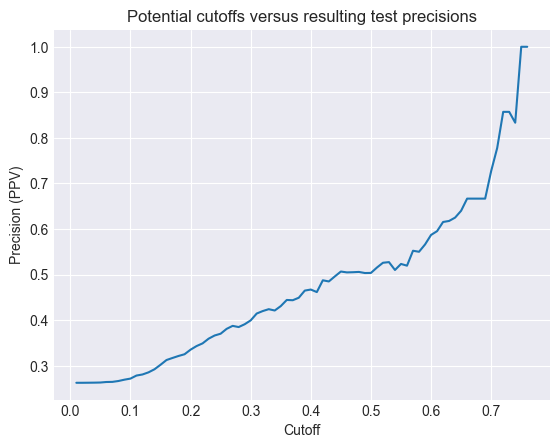

In [90]:
# Plotting decision cutoff vs. precision
# Making a grid of potential cutoff values (between 0, 1)
cutoffs = np.arange(1, 101) / 100  # Range of cutoffs

# Getting the test precisions with  list comprehension (could be a loop as well)
precisions = [y_test[rf_damage_pred_proba[:,1] > c].mean() for c in cutoffs]
#[rf_damageInd.predict_proba(X=X_test)[:,1] > c].mean() is a way to get the proportion of positively predicted values

# Plotts
plt.figure();
plt.plot(cutoffs, precisions);
plt.xlabel('Cutoff');
plt.ylabel('Precision (PPV)');
plt.title('Potential cutoffs versus resulting test precisions');

#### Calibration

To assess the calibration of a Random Forest Classifier and determine if the predicted probabilities are accurate, you can use a calibration curve. This curve compares the predicted probabilities to the actual outcomes. By plotting the predicted probabilities against the true probabilities, you can visually inspect the calibration of your model.

By examining this calibration curve, you can determine if the predicted probabilities align well with the actual outcomes. If the curve is close to the diagonal line (perfect calibration), it indicates that the model's predicted probabilities are accurate.

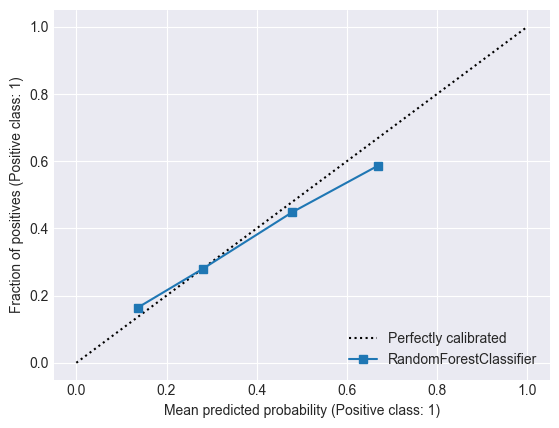

In [91]:
# Calibration curve 
from sklearn.calibration import CalibrationDisplay
CalibrationDisplay.from_estimator(estimator=rf_damageInd,
                                  X=X_test, 
                                  y=y_test,
                                  n_bins=5,
                                  strategy='uniform');

The prediction of the probability is close to the measured probability for the lower probabilities. For higher probabilities there is a lack of fit. 

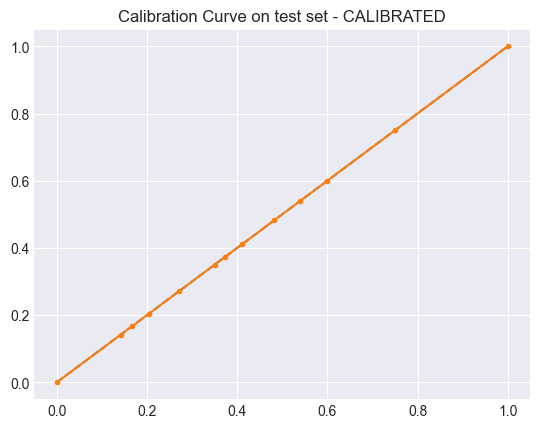

In [92]:
# Calibrating a RF model
# Importing necessary classes and function
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

# Doing isotonic regression on our RF model
rf_damageInd_isotonic = CalibratedClassifierCV(estimator=rf_damageInd, 
                                          cv='prefit', 
                                          method='isotonic')
rf_damageInd_isotonic.fit(X=X_test, y=y_test)

# Checking calibration curve on the calibration set
y_test_calibrated = rf_damageInd_isotonic.predict_proba(X=X_test)[:, 1]

# Plotting calibration curves after isotonic regression calibration
# skplt.metrics.plot_calibration_curve(y_true=y_test, probas_list=[y_test_calibrated], n_bins=10);
# plt.title('Calibration Curve on test set - CALIBRATED');
### ERROR on gctmap attribute in matplotlib? module 'matplotlib.cm' has no attribute 'get_cmap'

# Alternative way of plotting
first, second = calibration_curve(y_true=y_test, y_prob=y_test_calibrated, n_bins=20)  # Returns 2 arrays
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(first, second, marker='.')
plt.title('Calibration Curve on test set - CALIBRATED')
plt.show()

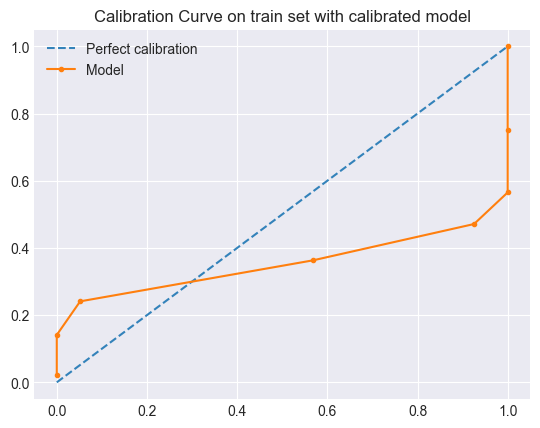

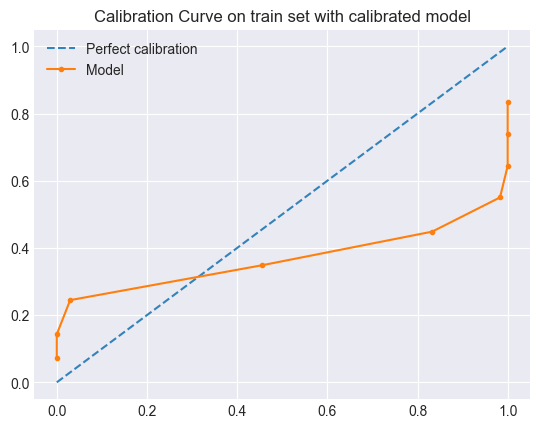

In [93]:
# Calibration curve after isotonic regression
y_pred_train_calibrated = rf_damageInd_isotonic.predict_proba(X=X_train)[:, 1]
y_pred_train_uncalibrated = rf_damageInd.predict_proba(X=X_train)[:, 1]

# Plotting calibration curves after isotonic regression calibration
# skplt.metrics.plot_calibration_curve(y_true=y_train, probas_list=[y_pred_train_calibrated], n_bins=10);
# plt.title('Calibration Curve on train set with calibrated model');

# Plotting calibration curves after isotonic regression calibration
# skplt.metrics.plot_calibration_curve(y_true=y_train, probas_list=[y_pred_train_uncalibrated], n_bins=10);
# plt.title('Calibration Curve on train set with raw model');

first, second = calibration_curve(y_true=y_train, y_prob=y_pred_train_calibrated, n_bins=10)
plt.plot([0, 1], [0, 1], linestyle='--', alpha=0.9, label='Perfect calibration')
plt.plot(first, second, marker='.', label='Model');
plt.legend();
plt.title('Calibration Curve on train set with calibrated model');
plt.show()

first, second = calibration_curve(y_true=y_train, y_prob=y_pred_train_uncalibrated, n_bins=10)
plt.plot([0, 1], [0, 1], linestyle='--', alpha=0.9, label='Perfect calibration')
plt.plot(first, second, marker='.', label='Model');
plt.legend();
plt.title('Calibration Curve on train set with calibrated model');
plt.show()

#### Lift curve

For us, the lift curve is an interesting tool, as it shows how much benefit the model has when you use it for selection. Typically, the cutoff is also made by assessing the two quantities shown on the lift curve: either one cuts the list off at a certain amount of benefit ("this will make my list that much purer"), or one cuts it off at a desired sample ("I'm able to contact 300 clients, which coincides with 10% of the population"). Note that the first logic is slightly suspect: usually there is a discrepancy between how you got the data, and how your future actions will work ("my data are from an administrative data base, and now I will use an email to contact new clients"), which means that the exact numbers are to be taken with a grain of salt. The second logic is better: if you have to contact 300 clients, these are probably the 300 best you can find.

The lift curve (or cumulative gains curve) is a common tool to talk about the strength of your lead list. 

In [94]:
# If you sum per row you just get 1, to know which proability is what, they are ordered as in the classes_ attribute
print(f"Ordering of the target classes: {rf_damageInd.classes_}")  # So False for col 0, True for col1!


Ordering of the target classes: [0 1]


In [95]:
#-- berekende classification lift
cuf.classification_lift(y_test.values,np.where(rf_damage_pred_proba[:,1]< 0.5, 0,1))

1.919102474753686

In [96]:
#-- cumulatieve lift
cumulative_lift = cuf.cumulative_classification_lift(y_test.values,np.where(rf_damage_pred_proba[:,1]< 0.5, 0,1))
type(cumulative_lift)

numpy.ndarray

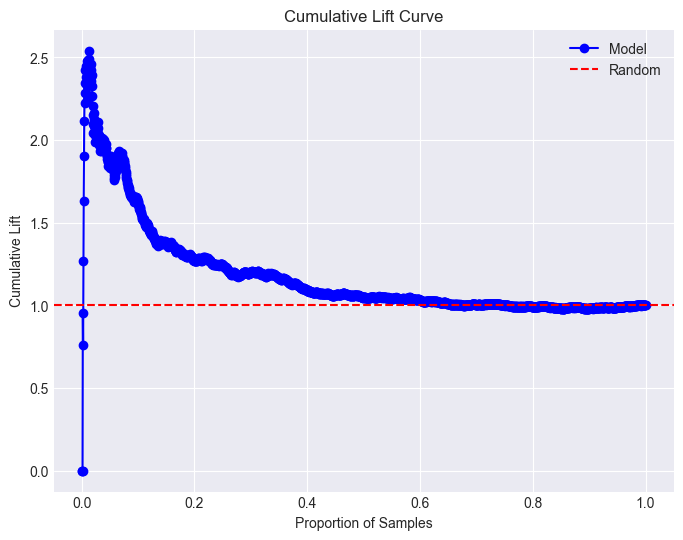

In [97]:
#-- Lift curve for clients causing damage ((rf_damage_pred_proba[:,1])
# 
plt.figure(figsize=(8, 6))
plt.plot(np.arange(1, len(cumulative_lift) + 1) / len(cumulative_lift), cumulative_lift, marker='o', linestyle='-', color='b')
plt.axhline(y=1, color='red', linestyle='--')
plt.xlabel('Proportion of Samples')
plt.ylabel('Cumulative Lift')
plt.title('Cumulative Lift Curve')
plt.legend(['Model', 'Random'])
plt.grid(True)
plt.show()

### Model to predict revenue per client 

Goal of the What do we need to predict? Is it available as outcome in our data
1. the revenue per client (= profit - damage)

We could fit the revenue by fitting the profit and by fitting the damage and subtracting them. Or we could calculate the revenue in the training set and fit the revenue as such.


In [ ]:
# # Making train-test set split and select the target = revenue
# X_train, X_test, y_train, y_test = train_test_split(train_V2.drop(['outcome_damage_amount','outcome_damage_inc','outcome_profit','revenue'], axis=1), # features DF
# #X_train, X_test, y_train, y_test = train_test_split(train_V2.drop(['outcome_damage_amount','outcome_damage_inc','outcome_profit','revenue','score_pos','score_neg','not_null_pos_columns','not_null_neg_columns'], axis=1), # features DF
#                                                     train_V2['revenue'],   # target DF/series
#                                                     test_size=0.2, 
#                                                     shuffle=True,  
#                                                     random_state=seed)  


# # Defining candidate grid to sample from (RandomizedSearchCV will sample from it)
# n_estimators = [int(x) for x in np.linspace(start=150, stop=300, num=10)]  # list comprehension because we want integers!
# max_depth = [int(x) for x in np.linspace(start=5, stop=80, num=5)]
# max_depth.append(None)  # adding 'None' option as well
# max_features = [0.7, 0.8, 0.85, 0.9, 0.95]
# min_samples_split = [4, 5, 6, 8]
# min_samples_leaf = [2, 3, 4]
# bootstrap = [True]
# hyperparam_grid = {'n_estimators': n_estimators,
#                    'max_features': max_features,
#                    'max_depth': max_depth,
#                    'min_samples_split': min_samples_split,
#                    'min_samples_leaf': min_samples_leaf,
#                    'bootstrap': bootstrap}

# # Define data splitter to be used in the search
# n_folds = 5
# kfold = KFold(n_splits=n_folds, shuffle=True, random_state=seed)

# # Define amount of hyperparameter tuning combinations to sample
# n_hyperparams_sample = 100

# # Defining model to apply random search CV hyperparam tuning on
# rf = RandomForestRegressor()

# # Initializing random search CV object
# rf_hyperparam_tuning_random = RandomizedSearchCV(estimator=rf, 
#                                           param_distributions=hyperparam_grid, 
#                                           n_iter=n_hyperparams_sample, 
#                                           cv=kfold,
#                                           verbose=2, 
#                                           random_state=seed, 
#                                           n_jobs=-1)

# # Fit the random search by sampling hyperparameters from our grid, then fitting each model for each CV fold, aggregating results
# rf_hyperparam_tuning_random.fit(X=X_train, y=y_train)

# print('Optimally found RF hyperparams after this random search: \n{}' .format(rf_hyperparam_tuning_random.best_params_))

# # Refitting the optimal model on the whole training dataset
# rf_revenue_best = rf_hyperparam_tuning_random.best_estimator_
# rf_revenue_best.fit(X=X_train, y=y_train)

# # Getting predictions on train and test set
# rf_revenue_best_y_train_pred = rf_revenue_best.predict(X=X_train)
# rf_revenue_best_y_test_pred = rf_revenue_best.predict(X=X_test)

# # Checking score (R2) manually
# print('Train R2: %.3f' % rf_revenue_best.score(X=X_train, y=y_train))
# print('Test R2: %.3f' % rf_revenue_best.score(X=X_test, y=y_test))
# pickle.dump(rf_revenue_best, open('..\\RF_model_revenue.pkl','wb'))

### HalvingRandomSearchCV: Randomized search on hyper parameters (experimental ).

The search strategy starts evaluating all the candidates with a small amount of resources and iteratively selects the best candidates, using more and more resources.

The candidates are sampled at random from the parameter space and the number of sampled candidates is determined by n_candidates.

For the model to predict profit we tried t

In [104]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV

from sklearn.ensemble import RandomForestClassifier

# Defining candidate grid to sample from (RandomizedSearchCV will sample from it)
n_estimators = [int(x) for x in np.linspace(start=150, stop=300, num=6)] 
max_depth = [int(x) for x in np.linspace(start=5, stop=85, num=8)]
max_depth.append(None)  # adding 'None' option as well
max_features = [0.7, 0.8, 0.9, 0.98]
min_samples_split = [4, 5, 6, 8]
min_samples_leaf = [2, 3, 4,6]
bootstrap = [True, False]
hyperparam_grid = {'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf,
                   'bootstrap': bootstrap}

# Define data splitter to be used in the search
n_folds = 5
kfold = KFold(n_splits=n_folds, shuffle=True, random_state=seed)

# Define amount of hyperparameter tuning combinations to sample
n_hyperparams_sample = 100

# Defining model to apply random search CV hyperparam tuning on
rf = RandomForestClassifier()

# Initializing random search CV object
rf_hyperparam_tuning = HalvingRandomSearchCV(estimator=rf, 
                                          param_distributions=hyperparam_grid, 
                                          factor=3,
                                          cv=kfold,
                                          verbose=1, 
                                          random_state=seed, 
                                          n_jobs=-1)

# Executing / fitting the random search 
rf_hyperparam_tuning.fit(X=X_train, y=y_train)
print('Optimal hyperparameter values according to our random search: \n{}' .format(rf_hyperparam_tuning.best_params_))

# Refitting the optimal model on the whole training dataset
rf_damageInd_hrs = rf_hyperparam_tuning.best_estimator_
rf_damageInd_hrs.fit(X=X_train, y=y_train)

# Getting predictions on train and test set
rf_damageInd_hrs_y_train_pred = rf_damageInd_hrs.predict(X=X_train)
rf_damageInd_hrs_y_test_pred = rf_damageInd_hrs.predict(X=X_test)

# Checking accuracy manually
print('Train accuracy of the refitted model: %.3f' % rf_damageInd_hrs.score(X=X_train, y=y_train))
print('Test accuracy of the refitted model: %.3f' % rf_damageInd_hrs.score(X=X_test, y=y_test))

# Classification report 
target_names = ['no damage', 'damage']
print(classification_report(y_true=y_test, y_pred=rf_damageInd_hrs_y_test_pred, target_names=target_names))

n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 20
max_resources_: 2967
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 148
n_resources: 20
Fitting 5 folds for each of 148 candidates, totalling 740 fits
----------
iter: 1
n_candidates: 50
n_resources: 60
Fitting 5 folds for each of 50 candidates, totalling 250 fits
----------
iter: 2
n_candidates: 17
n_resources: 180
Fitting 5 folds for each of 17 candidates, totalling 85 fits
----------
iter: 3
n_candidates: 6
n_resources: 540
Fitting 5 folds for each of 6 candidates, totalling 30 fits
----------
iter: 4
n_candidates: 2
n_resources: 1620
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Optimal hyperparameter values according to our random search: 
{'n_estimators': 210, 'min_samples_split': 5, 'min_samples_leaf': 6, 'max_features': 0.7, 'max_depth': 16, 'bootstrap': True}
Train accuracy of the refitted model: 0.886
Test accuracy of the refitted model: 0.743
         

# SVM

In [ ]:
# Standardizing
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().set_output(transform='pandas')
train_v2_stan_df = scaler.fit_transform(X=train_V2)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train_v2_stan_df.drop(target_features, axis=1), 
                                                    train_v2_stan_df["outcome_profit"],  
                                                    test_size=0.2,
                                                    shuffle=True, 
                                                    random_state=seed) 

In [ ]:
SVreg = svm.SVR()

In [ ]:
SVreg.get_params()

In [68]:
n_hyperparam_sample = 15

# Hyperparamters to be tuned
C = [round(x, 1) for x in np.arange(start=0.1, stop=1.0, step=0.2)]
cache_size = [x for x in np.arange(start=50, stop=1000, step=100)]
coef0 = [round(x,3) for x in np.arange(start=0.0, stop=10.0, step=4.0)]
degree = [int(x) for x in np.arange(1, 10, step=2)]
epsilon = [0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 1.0, 1.5, 2.0, 5.0, 10.0, 15.0, 20.0]
gamma = ['scale', 'auto', 0, 1, 2, 3, 4, 6, 8, 10, 20]
kernel = ['linear', 'poly', 'rbf', 'sigmoid']
max_iter = [-1, 1, 2, 5, 10, 15, 20, 30, 50, 75, 100]
shrinking = [True, False]
tol = [0.001, 0.002, 0.005, 0.01, 0.05, 0.1, 0.2, 0.5, 1.0, 5.0, 10.0, 15.0, 20.0]
verbose = [True, False]

params_grid = {'C': C,
               'cache_size': cache_size,
               'coef0': coef0,
               'degree': degree,
               'epsilon': epsilon,
               'gamma': gamma,
               'kernel': kernel,
               'max_iter': max_iter,
               'shrinking': shrinking,
               'tol': tol,
               'verbose': verbose}SVreg = svm.SVR()

In [ ]:
SVreg_tuning = RandomizedSearchCV(estimator=SVreg, 
                                param_distributions=params_grid, 
                                n_iter=n_hyperparam_sample,   # Amount of hyperparameter values to sample
                                cv=KFold(n_splits=5, shuffle=True, random_state=seed), # setting the shuffle to True here ... 
                                verbose=2, # to print some outputs
                                random_state=seed, 
                                n_jobs=-1)

In [ ]:
SVreg_tuning.fit(X_train, y_train)

In [ ]:
SVreg_tuning.score(X_train, y_train)

In [ ]:
SVreg_tuning.score(X_test, y_test)

In [ ]:
SVreg_tuning.best_params_

In [ ]:
SVreg_tuning.best_estimator_

In [ ]:
SVreg_results_profit_1 = pd.DataFrame(SVreg_tuning.cv_results_)
SVreg_results_profit

In [ ]:
SVreg_filtered = SVreg_results_1[SVreg_results_1['mean_test_score']>=-2]

In [ ]:
plt.scatter(x=SVreg_filtered['param_verbose'], y=SVreg_filtered['mean_test_score'], alpha=0.5);  # alpha=0.5 makes it a bit see through
plt.xlabel('tol');
plt.ylabel('mean_R2');
plt.show() 

## Damage occured?

In [ ]:
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(train_v2_stan_df.drop(target_features, axis=1), 
                                                    train_v2_stan_df["outcome_damage_inc"],  
                                                    test_size=0.2,
                                                    shuffle=True, 
                                                    random_state=seed) 

In [ ]:
SVcla = svm.SVC()

In [ ]:
SVcla.get_params()

In [ ]:
n_hyperparam_sample = 20

# Hyperparamters to be tuned
C = [round(x, 1) for x in np.arange(start=0.1, stop=1.0, step=0.2)]
cache_size = [x for x in np.arange(start=50, stop=1000, step=100)]
class_weight = [None, 'balanced', {0:1, 1:1}, {0:1, 1:2}, {0:1, 1:3}, {0:1, 1:4}, {0:2, 1:1}, {0:3, 1:1}, {0:4, 1:1}, {0:5, 1:1}, {0:6, 1:1}]
decision_function_shape = ['ovo', 'ovr']
break_ties = [True, False]
random_state = [None, 0, 1, 2, 6, 10, 20]
coef0 = [1.0, 2.0, 3.0]
degree = [1, 2, 3, 4]
gamma = ['scale', 'auto', 0, 1, 2, 3, 5]
kernel = ['linear', 'poly', 'rbf', 'sigmoid'] # POLY WEGGELATEN OMDAT DIT VOOR ZEER LANGE REKENTIJDEN ZORGDE, pre
max_iter = [-1, 1, 5, 10, 50, 75, 100]
shrinking = [True, False]
tol = [0.001, 0.005, 0.01, 0.1, 1.0, 10.0, 20.0]
verbose = [True, False]

params_grid_svc = {'C': C,
     'cache_size': cache_size,
     'class_weight': class_weight,
     'decision_function_shape': decision_function_shape,
     'break_ties': break_ties,
     'random_state': random_state,
     'coef0': coef0,
     'degree': degree,
     'gamma': gamma,
     'kernel': kernel,
     'max_iter': max_iter,
     'shrinking': shrinking,
     'tol': tol,
     'verbose': verbose}

In [ ]:
SVcla_tuning = RandomizedSearchCV(estimator=SVcla, 
                                param_distributions=params_grid_svc, 
                                n_iter=n_hyperparam_sample,   # Amount of hyperparameter values to sample
                                cv=KFold(n_splits=5, shuffle=True, random_state=seed), # setting the shuffle to True here ... 
                                verbose=2, # to print some outputs
                                random_state=seed, 
                                n_jobs=-1)

In [ ]:
SVcla_tuning.fit(X_train_c, y_train_c)

In [ ]:
SVcla_tuning.score(X_train_c, y_train_c)

In [ ]:
SVcla_tuning.score(X_test_c, y_test_c)

In [ ]:
SVcla_tuning.best_params_

In [ ]:
SVcla_results_1 = pd.DataFrame(SVcla_tuning.cv_results_)
SVcla_results_1

In [ ]:
plt.scatter(x=SVcla_results_1['param_cache_size'], y=SVcla_results_1['mean_test_score'], alpha=0.5);  # alpha=0.5 makes it a bit see through
plt.xlabel('tol');
plt.ylabel('mean_R2');
plt.show() 

In [ ]:
n_hyperparam_sample = 20

# Hyperparamters to be tuned
C = [0.1, 0.2, 0.3, 0.4, 0.6, 0.7, 0.8]
cache_size = [200, 225, 250, 275, 300, ]
class_weight = [None, 'balanced', {0:1, 1:1}, {0:1, 1:2}, {0:1, 1:3}, {0:1, 1:4}, {0:2, 1:1}, {0:3, 1:1}, {0:4, 1:1}, {0:5, 1:1}, {0:6, 1:1}]
decision_function_shape = ['ovo', 'ovr']
break_ties = [True, False]
random_state = [2, 3, 4, 5, 6, 8, 10, 12]
coef0 = [1.0, 2.0, 3.0]
degree = [1, 4, 5, 6]
gamma = ['auto', 2, 4, 5, 6, 7]
kernel = ['rbf', 'sigmoid'] # POLY WEGGELATEN OMDAT DIT VOOR ZEER LANGE REKENTIJDEN ZORGDE, pre
max_iter = [-1, 1, 2, 100, 200, 300, 500, 550, 600, 1000, 1500]
shrinking = [True, False]
tol = [0.01, 0.1, 0.2, 0.4, 0.6, 0.8, 1.0]
verbose = [True, False]

params_grid_svc_2 = {'C': C,
     'cache_size': cache_size,
     'class_weight': class_weight,
     'decision_function_shape': decision_function_shape,
     'break_ties': break_ties,
     'random_state': random_state,
     'coef0': coef0,
     'degree': degree,
     'gamma': gamma,
     'kernel': kernel,
     'max_iter': max_iter,
     'shrinking': shrinking,
     'tol': tol,
     'verbose': verbose}

In [ ]:
SVcla_tuning_2 = RandomizedSearchCV(estimator=SVcla, 
                                param_distributions=params_grid_svc_2, 
                                n_iter=n_hyperparam_sample,   # Amount of hyperparameter values to sample
                                cv=KFold(n_splits=5, shuffle=True, random_state=seed), # setting the shuffle to True here ... 
                                verbose=2, # to print some outputs
                                random_state=seed, 
                                n_jobs=-1)

In [ ]:
SVcla_tuning_2.fit(X_train_c, y_train_c)

In [ ]:
SVcla_tuning_2.score(X_train_c, y_train_c)

In [ ]:
SVcla_tuning_2.score(X_test_c, y_test_c)

In [ ]:
SVcla_tuning_2.best_params_

In [ ]:
SVcla_results_2 = pd.DataFrame(SVcla_tuning_2.cv_results_)
SVcla_results_2

## cost of the damage

In [ ]:
X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(train_V2.drop(target_features, axis=1), 
                                                    train_V2["outcome_damage_amount"],  
                                                    test_size=0.2,
                                                    shuffle=True, 
                                                    random_state=seed) 

In [ ]:
n_hyperparam_sample = 20

# Hyperparamters to be tuned
C = [round(x, 1) for x in np.arange(start=0.1, stop=1.0, step=0.2)]
cache_size = [x for x in np.arange(start=50, stop=1000, step=100)]
coef0 = [round(x,3) for x in np.arange(start=0.0, stop=10.0, step=4.0)]
degree = [int(x) for x in np.arange(1, 10, step=2)]
epsilon = [0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 1.0, 1.5, 2.0, 5.0, 10.0, 15.0, 20.0]
gamma = ['scale', 'auto', 0, 1, 2, 3, 4, 6, 8, 10, 20]
kernel = ['linear', 'poly', 'rbf', 'sigmoid']
max_iter = [-1, 1, 2, 5, 10, 15, 20, 30, 50, 75, 100]
shrinking = [True, False]
tol = [0.001, 0.002, 0.005, 0.01, 0.05, 0.1, 0.2, 0.5, 1.0, 5.0, 10.0, 15.0, 20.0]
verbose = [True, False]

params_grid_damage = {'C': C,
     'cache_size': cache_size,
     'coef0': coef0,
     'degree': degree,
     'epsilon': epsilon,
     'gamma': gamma,
     'kernel': kernel,
     'max_iter': max_iter,
     'shrinking': shrinking,
     'tol': tol,
     'verbose': verbose}

In [ ]:
SVreg_damage = RandomizedSearchCV(estimator=SVreg, 
                                param_distributions=params_grid_damage, 
                                n_iter=n_hyperparam_sample,   # Amount of hyperparameter values to sample
                                cv=KFold(n_splits=5, shuffle=True, random_state=seed), # setting the shuffle to True here ... 
                                verbose=2, # to print some outputs
                                random_state=seed, 
                                n_jobs=-1)

In [ ]:
SVreg_damage.fit(X_train_d, y_train_d)

In [ ]:
SVreg_damage.score(X_train_d, y_train_d)

In [ ]:
SVreg_damage.score(X_test_d, y_test_d)

In [ ]:
SVreg_damage.best_estimator_

In [2]:
SVreg_results_damage_1 = pd.DataFrame(SVreg_damage.cv_results_)
SVreg_results_damage_1

NameError: name 'pd' is not defined

## kNN

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train_V2.drop(['outcome_damage_amount','outcome_damage_inc','outcome_profit','revenue'], axis=1), # features DF
#X_train, X_test, y_train, y_test = train_test_split(train_V2.drop(['outcome_damage_amount','outcome_damage_inc','outcome_profit','revenue','score_pos','score_neg','not_null_pos_columns','not_null_neg_columns'], axis=1), # features DF
                                                    train_V2['outcome_profit'],   # target DF/series
                                                    test_size=0.2, 
                                                    shuffle=True,  
                                                    random_state=seed)  

# Flexible kNN regression on high-dimensional data : hyperparameter tuning > lower k 

n_neighbors = np.arange(1, 30)
hyperparam_grid = {'n_neighbors': n_neighbors} # GridSearchCV wants a dictionary ;)

n_folds = 5
kfold = KFold(n_splits=n_folds, shuffle=True, random_state=seed)

# Instantiate the model of choice
knn = KNeighborsRegressor()

# Instantiate the GridSearchCV object with our hyperparameter grid, amount of folds, ...
knn_hyperparam_tuning = GridSearchCV(estimator=knn, 
                                     param_grid=hyperparam_grid, 
                                     cv=kfold,  # supply the kfold object to the Grid search hyperparam tuning 
                                     verbose=2, 
                                     n_jobs=-1)  # For parallel computing on all available threads

# Carry out / fit using our data
knn_hyperparam_tuning.fit(X=X_train, y=y_train)

# Extracting best parameters
print(f'Optimal hyperparameters according to our grid search: {knn_hyperparam_tuning.best_params_}')
print('Train R2: %.3f' % knn_hyperparam_tuning.best_estimator_.score(X=X_train, y=y_train))
print('Test R2: %.3f' % knn_hyperparam_tuning.best_estimator_.score(X=X_test, y=y_test))


In [ ]:
print('Test R2: %.3f' % knn_hyperparam_tuning.best_estimator_.score(X=X_test, y=y_test))

In [ ]:
# Checking cross-validation results and visualizing
# Putting CV results in a nice Pandas DataFrame
knn_cv_results = pd.DataFrame(knn_hyperparam_tuning.cv_results_)

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(x=knn_cv_results['param_n_neighbors'], y=knn_cv_results['mean_test_score']);
plt.title('Amount of neighbors (k) vs. CV R2 (Zoomed out)');
plt.xlabel('Amount of neighbors (k)');
plt.ylabel('CV R2');

In [ ]:
# Checking cross-validation results and visualizing
# Putting CV results in a nice Pandas DataFrame
knn_cv_results = pd.DataFrame(knn_hyperparam_tuning.cv_results_)

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(x=knn_cv_results['param_n_neighbors'], y=knn_cv_results['mean_test_score']);
plt.title('Amount of neighbors (k) vs. CV R2 (Zoomed out)');
plt.xlabel('Amount of neighbors (k)');
plt.ylabel('CV R2');



# Whiteboxing and explainability

Because we see that the RF model for predicting profit performs better we will use this to investigate:
- which features matter?  
- what is the influence of a feature?  
- why is the prediction what it is?  

To evaluate the results and not having to run the cross validation repeatedly the selected models were saved and are reloaded below


In [105]:
rf_profit_best = pickle.load(open('..\\RF_model_profit.pkl','rb'),encoding='utf-8')
rf_damage_amount_best = pickle.load(open('..\\RF_model_damage_amount.pkl','rb'),encoding='utf-8')
rf_damage_inc_best = pickle.load(open('..\\RF_model_damage_inc.pkl','rb'),encoding='utf-8')
rf_damage_inc_hrs_best = pickle.load(open('..\\RF_model_damage_inc_hrs.pkl','rb'),encoding='utf-8')
#rf_revenue_best = pickle.load(open('..\\RF_model_revenue.pkl','rb'),encoding='utf-8')


FileNotFoundError: [Errno 2] No such file or directory: '..\\RF_model_profit.pkl'

In [ ]:
#-- Needed for explainability: Mind to use the correct target for the corresponding model

train_V2 = pd.read_csv('..\\train_V2_prep.csv')
score = pd.read_csv('..\\score_prep.csv')
rf_profit_best = pickle.load(open('.\\RF_model_profit.pkl','rb'),encoding='utf-8')

X_train, X_test, y_train, y_test = train_test_split(train_V2.drop(['outcome_damage_amount','outcome_damage_inc','outcome_profit','revenue'], axis=1), # features DF
#X_train, X_test, y_train, y_test = train_test_split(train_V2.drop(['outcome_damage_amount','outcome_damage_inc','outcome_profit','revenue','score_pos','score_neg','not_null_pos_columns','not_null_neg_columns'], axis=1), # features DF
                                                    train_V2['outcome_profit'],   # target DF/series
                                                    test_size=0.2, 
                                                    shuffle=True,  
                                                    random_state=seed)  

## Tree-based (global) feature importances (which features matter?)

In [ ]:
# Getting feature importances of the fitted rf1 model (looking at first 10 rows)
rf_profit_best.feature_importances_[0:10]

In [ ]:
# Understanding which features or variables have the most impact on the model's predictions
# Feature importance in a Random Forest model is determined by how much each feature contributes to decreasing the impurity in the nodes of the trees within the forest.
# rf_profit_best.feature_importances_[0:10]

# Putting feature importances of our random forest model into a DataFrame and show the 10 most important features
rf_profit_best = (pd.DataFrame({'feature': X_train.columns, 
                        'feature_importance': rf_profit_best.feature_importances_})
          .sort_values(by='feature_importance', ascending=False)
          .reset_index(drop=True)) # resetting index

rf_profit_best.head(10)

In [ ]:
# Visualize top k feature importances
# Extracting top k
_k = 20
rf_profit_best_top_k = rf_profit_best.head(_k).sort_values(by='feature_importance', ascending=True)

# Plotting
plt.barh(y=rf_profit_best_top_k['feature'], width=rf_profit_best_top_k['feature_importance'], color='deepskyblue'); # pretty colors wow
plt.xlabel('Scaled feature importance');
plt.ylabel('Feature');
plt.title(f'Top {_k} feature importance for model rf1');

In [ ]:
# Permutation feature importances - this will take a while (~3 min)
rf_profit_best_fi_perm = permutation_importance(estimator=rf_profit_best, 
                                     X=X_train, 
                                     y=y_train, 
                                     n_repeats=5,  # 5 permutation runs! 
                                     random_state=seed)

# Converting to a Pandas DataFrame & sorting
rf_profit_best_fi_perm_df = (pd.DataFrame({'feature': X_train.columns,
                               'importances_mean': rf_profit_best_fi_perm['importances_mean'],
                               'importances_std': rf_profit_best_fi_perm['importances_std']})
                  .sort_values(by='importances_mean', ascending=False)
                  .reset_index(drop=True))
rf_profit_best_fi_perm_df.head(5)

In [ ]:
# Plotting the top 20 result again, with error bars
# Getting top k
_k = 20
rf_profit_best_df_top_k = (rf_profit_best_fi_perm_df
                        .head(_k) # take top 20
                        .sort_values(by='importances_mean', ascending=True))

# Plotting with error bars
plt.barh(y=rf_profit_best_df_top_k['feature'], 
         width=rf_profit_best_df_top_k['importances_mean'], # size of the bar is the avg. importance
         xerr=rf_profit_best_df_top_k['importances_std'],  # error bar is the standard deviation
         color='deepskyblue');  # For error bars, handy!
plt.xlabel('Permutation-based scaled feature importances');
plt.ylabel('Feature');
plt.title('Permutation-based feature importances for model rf1');

In [ ]:
#-- drop-column feature importances: assessing the impact or importance of a specific feature (column) in a machine learning model.
#   By dropping the column and observing the change in model performance, you can gauge the significance of that particular feature in predicting the target variable.
rf_profit_best_importances_drop = cuf.drop_col_feat_imp(model=rf_profit_best, 
                                         X=X_train, 
                                         y=y_train, 
                                         random_state=seed)

rf_profit_best_importances_drop.head(5)

In [ ]:
# Plotting top k of drop-column feature importances
_k = 20
rf_profit_best_importances_drop_top_k = (rf_profit_best_importances_drop.sort_values(by='importance', ascending=False)
                             .head(_k)
                             .sort_values(by='importance', ascending=True)) # To get it to plot nicely (sort WITHIN top _k)

# Plotting
plt.barh(y=rf_profit_best_importances_drop_top_k ['feature'], 
         width=rf_profit_best_importances_drop_top_k['importance'], 
         color='deepskyblue', 
         ecolor='black');
plt.title('Drop-column method feature importances')
plt.xlabel('Importance');
plt.ylabel('Feature');



## Linear surrogate explainability models (what is the influence of a feature)

Feature importances only tell us one thing for each feature: was it important for the whole model under consideration or not? There are other questions to answer: exactly how are the features related to the target variable, which direction and what magnitude? To this end, we build a surrogate regression model that uses the predicted value from the model you want to explain as a target. Obviously, we want this surrogate model to be explainable to some degree, and this is why linear regression comes into play.

It really doesn't matter in which set you calculate this, as long as it is representative of the population you want to discuss. Here, we do it just for the train set.

The first step is to get the predictions from the (main) random forest that we try to whitebox in the first place. Then, we will prepare a series of univariate (1D) regressions. To make the results comparable, we standardize all features. Note that the set of predictions (which is used as the outcome for the regressions) itself is also standardized, to make the beta's more interpretable.


In [ ]:
# Relating feature importances to the target with linear surrogate models
from sklearn.linear_model import LinearRegression  # We will be needing our linear regression class

# Getting predicted values for the model we want to inspect
rf_profit_best_preds_train = rf_profit_best.predict(X=X_train)

# Standardize y
y_pred_norm = np.array((rf_profit_best_preds_train-rf_profit_best_preds_train.mean()) / np.sqrt(rf_profit_best_preds_train.var())).reshape(-1, 1)

# Fit a univariate linear regression for all predictors separately, using predicted value from Random Forest as target here!
beta_surrogate_summary = pd.Series(index=X_train.columns, name='beta', dtype='float')  # Initialize empty Pandas Series with column names as rowindex
for feat in X_train.columns:
    current_X = np.array(X_train[feat]).reshape(-1, 1)  # because 1D regression
    reg_surrogate = LinearRegression().fit(X=current_X, y=y_pred_norm)
    
    # Extracting estimated beta and putting it in our big 'beta' overview Series, using .at[]
    beta_surrogate_summary.at[feat] = reg_surrogate.coef_[0] 

# Checking result on 5 coeffs
print('5 coefficients of our surrogate univariate regressions for explainability, summarized:')
beta_surrogate_summary.head(5)

In [ ]:
# Plotting the top k (20) univariate regression coefs in absolute value
_k = 20
# TRICK TO SORT ON ABSOLUTE VALUE (key=abs)!
beta_surrogate_summary_top_k = (beta_surrogate_summary.sort_values(key=abs, ascending=False)
                                .head(_k)
                                .sort_values(key=abs, ascending=True)) # trick to order on absolute value :)

# Plotting
plt.barh(y=beta_surrogate_summary_top_k.index, width=beta_surrogate_summary_top_k, color='deepskyblue');
plt.xlabel('Normalized univariate regression coefficient')
plt.ylabel('Feature');
plt.title(f"Top {_k} regression coefficients to explain model rf_profit_bes");

In [ ]:
# Showing strongest top 5 negative features
print('Most negative univariate betas:')
beta_surrogate_summary.sort_values(ascending=True).head(5)

In [ ]:
# Showing strongest top 5 positive features
print('Most positive univariate betas:')
beta_surrogate_summary.sort_values(ascending=False).head(5)

In [ ]:
# Checking how the permuation importance features do on the univariate surrogate models
beta_surrogate_summary.loc[rf_profit_best_df_top_k['feature']]

In [ ]:
# Surrogate multiple linear regression model (only on top 20 models of permutation importance on rf1)
# Getting normalized features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(with_mean=True, with_std=True)
scaler.fit_transform(X=X_train[rf_profit_best_df_top_k['feature']])

X_train_norm = scaler.transform(X_train[rf_profit_best_df_top_k['feature']])
y_pred_train_norm = np.array((rf_profit_best_preds_train - rf_profit_best_preds_train.mean()) / np.sqrt(rf_profit_best_preds_train.var())).reshape(-1, 1)

# Fitting model
multiple_surrogate_reg = LinearRegression().fit(X=X_train_norm, y=y_pred_train_norm)
# Do .values otherwise df will be mangled up! due to non-sorted indices of rf1_fi_perm_df_top_k
beta_surrogate_multiple_summary = pd.DataFrame(data={'feature': rf_profit_best_df_top_k['feature'].values,
                                                     'coef': multiple_surrogate_reg.coef_[0]})
print(beta_surrogate_multiple_summary.sort_values(by='coef', key=abs, ascending=False))

## why is the prediction what it is
### tree interpreter

In [ ]:
X_train.loc[44, :].values

In [ ]:
## Why is the prediction what it is?
# Instance (observation)-based explanations using treeinterpreter package
# Import tree interpreter functionalities
from treeinterpreter import treeinterpreter as ti, utils

# We choose a single row (instance, observation) to explain
selected_ids = [44]  # hotel guest nr. 44
selected_df = X_train.loc[selected_ids, :].values  #use .loc (because our 'Id' column is now the index :))

# Getting predictions, biases and contributions
prediction, bias, contributions = ti.predict(model=rf_profit_best, X=selected_df)

for i in range(len(selected_ids)):
    print('Guest Id', selected_ids[i])
    print('Prediction:', prediction[i][0], 'Actual Value:', y_train[selected_ids[i]])
    print('Bias (trainset mean)', bias[i])
    print('Feature contributions:')
    for c, feature in sorted(zip(contributions[i], X_train.columns), key=lambda x: -abs(x[0])):
        # Only show nonzero - cleaner
        if c != 0.0:
            print(feature, round(c, 2))
            print('-' * 20)         

### LIME

In [ ]:
# Instance (observation)-based explanations using LIME
# Importing packages
#import lime
from lime.lime_tabular import LimeTabularExplainer

# Taking features that have less than 10 unique values as categorical, getting their INDEX! (np.argwhere())
cat_feats_idx = np.argwhere(np.array([len(set(X_train.values[:, x])) 
                                      for x in range(X_train.values.shape[1])]) <= 10).flatten()
# Instantiating LIME LimeTabularExplainer class
explainer = LimeTabularExplainer(training_data=X_train.values,  # Needs to be np.array, hence .values, bit weird!
                                 mode='regression',
                                 categorical_features=cat_feats_idx,
                                 feature_names=X_train.columns,
                                 discretize_continuous=True,
                                 random_state=seed)

# Doing actual explanation using .explain_instance()
explanation = explainer.explain_instance(data_row=X_train.loc[selected_ids[0]].values,   
                                         predict_fn=rf_profit_best.predict, 
                                         num_features=10)
explanation.show_in_notebook(show_all=False) # we ask lime to only display the features used in the explanation

### SHAP

In [ ]:
# Importing shap package
import shap

# Instantiate and explain using shap
explainer = shap.TreeExplainer(model=rf_profit_best)
shap_values = explainer.shap_values(X_train)

# 'bar'-type summary plot
shap.summary_plot(shap_values=shap_values, 
                  features=X_train, 
                  plot_type='bar')

In [ ]:
# -- Lift curve
lift = cuf.plot_lift_curve(X_train,y_train, rf_damage_inc_best)


In [ ]:
# visualize the first prediction's explanation with a force plot - GDB
#shap.plots.force(shap_values[0])
# explainer = shap.Explainer(model=rf_profit_best)
# shap_values = explainer(X_train)
# shap.plots.waterfall(shap_values[0])

# Selected list of hotel guest and what does the manager gain in applying the selection

In [ ]:
score['revenue_pred'] = rf_profit_best.predict(score) - rf_damageAmount.predict(score)

selection = score.sort_values('revenue_pred', ascending=False).head(200)
sample = score.sample(200)

total_revenue_selection = selection['revenue_pred'].sum()
total_revenue_sample = sample['revenue_pred'].sum()

print('The estimated revenue of the selection is %.3f, ' % total_revenue_selection)
print('The estimated revenue of the sample is %.3f, ' % total_revenue_sample)
print('This means that by applying the selection the model identified you gain %.3f!!! ' % (total_revenue_selection - total_revenue_sample))
#print('Train R2: %.3f' % gbm.score(X=X_train, y=y_train))

# For EXECUTIVE SUMMARY : 

## Winst 200 geselecteerde tov winst voor random sample van hotel guest

Based on the analysis conducted using various algorithms like Random Forest, GBM, and SVR on the training data, a list of hotel guests has been selected for targeted marketing efforts. The best-performing model was identified through cross-validation and hyperparameter tuning.

The gain achieved from the selected list of hotel guests is significant, with a calculated gain of 152,189.787 compared to the revenue from a random sample, which was 343,572.614. This indicates that targeting the selected list of hotel guests can potentially lead to increased revenue for the hotel.

It is recommended that the hotel manager consider applying the selected list of hotel guests for tailored marketing strategies to capitalize on the potential revenue increase. By focusing efforts on these specific guests, the hotel can optimize its marketing initiatives and enhance overall profitability.